# Хакатона Практикум х Яндекс Музыка
# Проект: Обнаружение каверов музыкальных треков
# Команда: Deadline "Yesterday"


**Бизнес-задача:**

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

**Цель:**

Улучшение качества рекомендаций музыкального сервиса путем точного определения и классификации каверов.

В этом хакатоне предлагается разработать решение, которое:
- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Совсем не обязательно, чтобы решение умело делать все три функции. 

Для решения этой задачи можно использовать любые открытые источники данных и собирать необходимую информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.



**Представленные закзачиком данные:**

1. **Разметка каверов**

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

<aside>
    
💡 Не для всех каверов известны идентификаторы исходных треков!

</aside>


2. **Метаинформация**

Файл meta.json

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

ISRC - Международный стандартный номер аудио- или видеозаписи (International Standard Recording Code) \
Код ISRC всегда состоит из 12 символов и записывается в формате «CC-XXX-YY-NNNNN» (Дефисы не являются частью кода ISRC, но этот код часто пишут таким образом, чтобы облегчить его чтение.) Упомянутые выше четыре части означают:

- "CC" - это соответствующий двухсимвольный код страны для эмитента ISRC. Код присвоен в соответствии со стандартом ISO 3166-1-Alpha-2. (Высокий спрос на ISRC в Соединенных Штатах привел к исчерпанию предложения доступных кодов владельцев регистраций; после 6 декабря 2010 года новые владельцы регистраций в США используют код страны "QM". Коды "CP" и "DG" зарезервированы для дальнейшего переполнения, а "ZZ" зарезервировано для кодов, присвоенных Международным агентством ISRC. Продолжают вноситься дальнейшие дополнения.)
- «XXX» — трёхзначный алфавитно-цифровой регистрационный код, уникальным образом определяющий организацию, которая регистрирует код. Например, в Великобритании это Phonographic Performance Limited (PPL).
- «YY» — последние две цифры года регистрации (не обязательно соответствуют году, когда произведена запись)
- «NNNNN» — уникальная последовательность из пяти цифр, определяющая определённую аудиозапись.

Например, GBEMI0300013.

Например, запись песни «Enquanto Houver Sol», выполненная бразильской группой Titãs, получила код ISRC BR-BMG-03-00729:

- BR для Бразилии
- BMG для BMG
- 03 для 2003 года
- 00729 уникальный идентификатор записи

Другой пример: USPR37300012 — запись песни «Love's Theme» группы Love Unlimited Orchestra.

- US-PR3-73/00012
- US для США
- PR3 для организации
- 73 для 1973 года
- 00012 уникальный идентификатор записи

Стоит учесть, что номер определяет именно конкретную запись, а не песню в целом.


3. **Текст песен**

Файл lyrics.json

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## Устанавливаем и импортируем библиотеки

In [1]:
!pip install pywsd

In [2]:
!python -m spacy download xx_sent_ud_sm

/Users/manyak_pro/anaconda3/bin/python: No module named spacy


In [3]:
!python -m spacy download es_core_news_md

/Users/manyak_pro/anaconda3/bin/python: No module named spacy


In [4]:
import os
import re
import time
import sys
import datetime
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from iso639 import Lang
from iso3166 import countries
import langid


from pymystem3 import Mystem
from pymorphy3 import MorphAnalyzer

import nltk
#from nltk.corpus import stopwords as nltk_stopwords
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import spacy
from spacy.lang.es.examples import sentences 
import simplemma


from pywsd.utils import lemmatize_sentence

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline


from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)

import catboost as cb

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    make_scorer
)



Warming up PyWSD (takes ~10 secs)... took 3.3973989486694336 secs.


In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
#загружаем необходимые дополнения для библиотеки
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet') 
nltk.download('punkt')
nltk.download('stopwords') 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manyak_pro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manyak_pro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manyak_pro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manyak_pro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
pd.options.display.max_colwidth = 0
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
RANDOM_STATE = 20231031
max_len = 512

## Написанные для проекта функции

In [9]:
def unique_info(data, value):
    print()
    print(
        f"Кол-во уникальных знаечний в столбце {value}:", data.loc[:, value].nunique()
    )
    print()
    print(f"Cписок уникальных значений в столбце {value}:")
    print(data[value].sort_values().unique())
    print()


In [10]:
def plot_info_cover(value,data):

    df_group_cover = (
        data[data["track_remake_type"] != "ORIGINAL"]
        .groupby(value, as_index=False)["track_id"]
        .count()
        .sort_values(by="track_id", ascending=False).rename(columns={'track_id': 'count'})
    )
    print(f'#ТОП-10:{value}')
    display(df_group_cover.head(10))#ТОП-10

    print()
    df_group_cover[:30].plot(value,'count',kind='bar', figsize=(15,5), grid = True)
    plt.title(f'Распределение кол-ва каверов по {value}')
    plt.xlabel(value)
    plt.ylabel('Количество песен')
    plt.show()

In [11]:
def plot_info_original(value,data):

    df_group_origin = (
        data[data["track_remake_type"] == "ORIGINAL"]
        .groupby(value, as_index=False)["track_id"]
        .count()
        .sort_values(by="track_id", ascending=False).rename(columns={'track_id': 'count'})
    )
    print(f'#ТОП-10:{value}')
    display(df_group_origin.head(10))#ТОП-10

    print()
    df_group_origin[:30].plot(value,'count',kind='bar', figsize=(15,5), grid = True)
    plt.title(f'Распределение кол-ва оригиналов по {value}')
    plt.xlabel(value)
    plt.ylabel('Количество песен')
    plt.show()

In [12]:
def plot_info_all(value,data):

    df_group = (
        data
        .groupby(value, as_index=False)["track_id"]
        .count()
        .sort_values(by="track_id", ascending=False).rename(columns={'track_id': 'count'})
    )
    print(f'#ТОП-10:{value}')
    display(df_group.head(10))#ТОП-10

    print()
    df_group[:30].plot(value,'count',kind='bar', figsize=(15,5), grid = True)
    plt.title(f'Распределение кол-ва всех треков по {value}')
    plt.xlabel(value)
    plt.ylabel('Количество песен')
    plt.show()

## 1. Загрузка файлов и ознакомление с данными

**Считаем данные из json-файлов в датафрейм и сохраним в переменные df. Путь к файлам:**

In [13]:
url_covers = "./data/covers.json"
url_lyrics = "./data/lyrics.json"
url_meta = "./data/meta.json"


Выполним чтение файлов:

In [14]:
try:
    df_covers = pd.read_json(url_covers, lines=True)
    df_lyrics = pd.read_json(url_lyrics, lines=True)
    df_meta = pd.read_json(url_meta, lines=True)
except:
    print(
        "Один или несколько файлов не найдены. Проверьте путь до файла(ов) или само наличие датафрейма(ов) на компьютере"
    )

Ознакомимся с прочтенными файлами. Выполним вывод первых строк и общей информации о датафрейме

#### Таблица `covers.json`

Выведим первые 10 строк таблицы

In [15]:
df_covers.head(10)

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
5,None,4da9d7b6d119db4d2d564a2197798380,COVER
6,None,2bf283c05b601f21364d052ca0ec798d,COVER
7,None,5eb13cb69b6e20dd7a42030f5936a9dc,COVER
8,None,109f91266ef89cc3690079b28abfe9a3,COVER
9,76c538125fc5c9ec6ad1d05650a57de5,76c538125fc5c9ec6ad1d05650a57de5,ORIGINAL


In [16]:
df_covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


Всего в таблице 71597 строк и 3 столбца. \
Все столбцы соотеветсвуют заявленным типам данным.\
В столбце original_track_id(уникальный идентификатор исходного трека) присутсвует большое кол-во пропусков.\
Предположения почему у песни отсутвует информация об оригинале:
- Автор(ы) оригинала неизвестны или забыты со временем (к примеру, народные песни). На них каверы тоже делаются. К примеру, песня "House of the rising sun" является кавером и известна она обычно в исполнении группы The Animals.
- не смогли идентифицировать оригинал, так как песня содержит элементы из разных источников. Такие моменты бывают у рэп исполнителей. Или, к примеру, группа Prodigy, которая в каждой своей песне испоьзовала сэмплы из разных источников.
- не смогли идентифицировать оригинал, к примеру, так как слова взяты из стихов извесных поэтов, но музыка оригинальная.
- забыли указать. Человеческий фактор. необходимо проверить, что в столбце original_track_id нет пропуска, если песня оригинал.

Посмотрим на уникальные значения в каждом столбце

In [17]:
for value in df_covers.columns:
    unique_info(df_covers,value)


Кол-во уникальных знаечний в столбце original_track_id: 4468

Cписок уникальных значений в столбце original_track_id:
['000801d33025623d7de5b42f40b37ddf' '00438ab276734220281a3e99b66a2c28'
 '004d29e7ffa764a18c4d1a0bf74b0093' ... 'fff177e8cb2740a02ee8a5fbe77268fb'
 'ffff9a22aa441db772206280ffb8b52e' None]


Кол-во уникальных знаечний в столбце track_id: 71597

Cписок уникальных значений в столбце track_id:
['0000757a652c12554a82002cd90cc10a' '00017038a565df4b72048268e7623599'
 '0002e85381698128b8b2a0f578ac2054' ... 'fffefc046267a3f6263fc2c8d0f3f871'
 'ffff8f1c01d78267ce067a2507fcc8f8' 'ffff9a22aa441db772206280ffb8b52e']


Кол-во уникальных знаечний в столбце track_remake_type: 2

Cписок уникальных значений в столбце track_remake_type:
['COVER' 'ORIGINAL']



Всего представлено 4468 оринигальных треков. Информация по которым известна. Треки же в track_id все уникальные.

Проверим, что нет ситуации, что указали что трек является оригиналом, но забыли продублировтаь track_id в original_track_id

In [18]:
df_covers[(df_covers['track_remake_type'] == 'ORIGINAL') & (df_covers['original_track_id'].isna() == True)]

,original_track_id,track_id,track_remake_type


Такие строки отсутсвуют

Посмотрим сколько треков не имеют каверов

In [19]:
count_original_track_id_by_track_id = df_covers.groupby('original_track_id',as_index=False)['track_id'].count()

In [20]:
print('Кол-во оригинальных треков без каверов:',
      len(count_original_track_id_by_track_id[count_original_track_id_by_track_id['track_id'] == 1]))

Кол-во оригинальных треков без каверов: 4403


In [21]:
print('Кол-во оригинальных треков имеющие каверы в наборе:',
      len(count_original_track_id_by_track_id[count_original_track_id_by_track_id['track_id'] != 1]))

Кол-во оригинальных треков имеющие каверы в наборе: 65


Поскольку нам необходимо будет решать задачу классификации. Посмотрим как в целевом признаке рапределены ответы.

track_remake_type
COVER       0.940039
ORIGINAL    0.059961
Name: proportion, dtype: float64


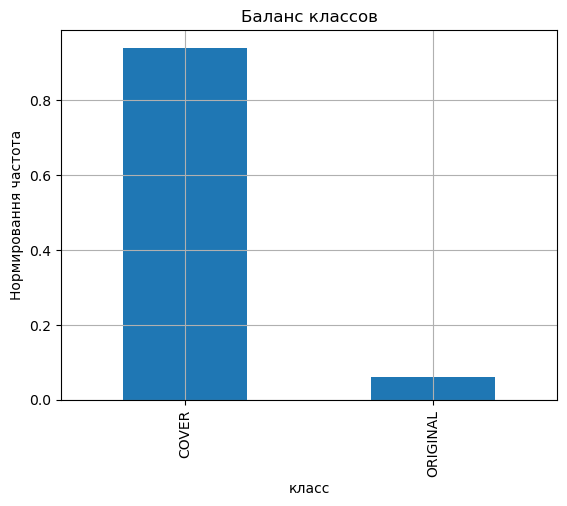

In [22]:
class_frequency = df_covers['track_remake_type'].value_counts(normalize=True) 
print(class_frequency)
class_frequency.plot(kind='bar',
                    grid=True)
plt.title("Баланс классов")
plt.xlabel("класс")
plt.ylabel("Нормировання частота")
plt.show()

По гистограмме наблюдается несбаласированность классов. Проверять на константной модели нет необходимости.

Для балансировки классов можно выполнить:

- уменьшение выборки с ответом COVER .
- увеличение выборки с ORIGINAL до кол-ва ответов с COVER.
- Взвешивание классов

Принятие решение о способе балнсировки классов будем после подготовки данных к обучению

Проверим данные на дубликаты в строках

In [23]:
df_covers.duplicated().sum()

0

#### Таблица `lyrics.json`

выведим первые 3 строки таблицы

In [24]:
df_lyrics.head(3)

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\nПопытками не то любить, что нужно\nТеряю смысл, ну и пусть, невыносимой стала грусть\nИ в комнате, что с потолком мне чужда\n\nЯ б уплыла в океан, сшила б красный сарафан, и... И...\nЯ б забыла, что ты есть, я б не лезла в эту сеть\nЯ бы, я бы, я бы, я бы не была бы здесь\n\nВолосы пропахли дымом, вечер был довольно длинным...\n\nЖиву сейчас попытками, попытками не пытками\nНайти себя и что-нибудь родное\nИщу я что-то, где-то там, пью чёрный кофе по утрам\nИ не пойму - да что ж это такое?\n\nЯ б уплыла в океан, сшила б красный сарафан, и... И...\nЯ б забыла что ты есть, я б не лезла в эту сеть\nЯ бы, я бы, я бы, я бы не была бы здесь\n\nЯ б уплыла в океан, сшила б красный сарафан, и... И...\nЯ б забыла что ты есть, я б не лезла в эту сеть\nЯ бы, я бы, я бы, я бы не была бы здесь\n\nВолосы пропахли дымом, вечер был довольно длинным...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,"Tell me your fable\nA fable\nTell me your fable\nTell me your fable\nTell me your fable\nA fable\nTell me your fable\nTalk to me, tenderly\nShow reality, fantasy\nWe'll bound together\nAll win in one feat\nTalk to me, tenderly\nShow reality, fantasy\nWe'll bound together\nAll win in one feat\nThe fable, the fable, ah\nThe fable, the fable\nTell me your fable\nTell me your fable\nA fable, a fable\nA fable that will never end\nAnd now, I dream\nDream, dream",0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,"You're ashamed about all your fears and doubts\nAnd how I hurt you\nCan you make it back from the aftermath?\nAnd how I left you\nNobody wants to be alone\nWith the fear of letting go\nIf you could hear me say it's gonna be ok\nWould you be ok?\n\nAnd though I've gone away\nI still see what you're going through\nIt kills me everyday\nTo know I killed what meant most to you\nSo when you pass my grave\nLeave a rose for what might have been\nBut know that it's ok\nYou shed your fears and find love again\n\nFor better or worse, you're the one I never thought I'd hurt\nBut looking back on these dreams\nNothing is what it seems\nKnow that you wake up to better things\n\nAnd though I've gone away\nI still see what you're going through\nIt kills me everyday to know I killed what meant most to you\nSo when you pass my grave\nLeave a rose for what might have been\nBut know that it's ok to shed your fears and find love again\n\nI hear you say\nI don't know how and I don't know why\nBut there will come one day when I will tell you all the things inside\nJust know there's someone above you to help you\n\nAnd though I've gone away\nI still see what you're going through\nIt kills me everyday to know I killed what meant most to you\nSo when you pass my grave\nLeave a rose for what might have been\nBut know that it's ok to shed your fears\nAnd find love again\n\nI'm sorry I broke you\nBut there was nothing that you could do\nOh I never thought it would end this way\nAnd now there's nothing that we can say but goodbye\nGoodbye\nAll we have left is goodbye\nOh goodbye",9c6dc41d5ccd9968d07f055da5d8f741


In [25]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


Всего в таблице 11414 строк и 3 столбца. \
Все столбцы соотеветсвуют заявленным типам данным.\
Пропуски отсуствуют в таблицах.\
Также в столбце text наблюдается, что текст требует предобработки и приведение к необходиому виду для дальнейшего обучения. Также замечено, что текст представлен на разных языках. Необходимо будет проанализировать какие языки представлены в текстах треках \
Посмотрим на уникальные кол-во значений в каждом столбце.

In [26]:
for value in df_lyrics.columns:
    print(
        f"Кол-во уникальных знаечний в столбце {value}:", df_lyrics.loc[:, value].nunique()
    )
    print()

Кол-во уникальных знаечний в столбце lyricId: 10915

Кол-во уникальных знаечний в столбце text: 10644

Кол-во уникальных знаечний в столбце track_id: 10277



Наблюдается различие в уникальных значениях в каждом столбце. 

Посмотрим есть ли дубликаты строк

In [27]:
df_lyrics.duplicated().sum()

0

Дубликаты отсутствуют

В столбцах:
- lyricId - возможны дубликаты, так как треки разные, но текст одинаковый( к примеру, оригинал и его переиздание или кавер и оригинал, где перепевка песни не вносила существенные корреткивы в текст) 
- text - возможны дубликаты, так как текст трека может повторяться
- track_id - присутсвуют дубликаты треков. 

Посчитаем сколько раз всречаются дубликаты

In [28]:
count_track_id_by_lyricId_by = df_lyrics.groupby('track_id',as_index=False)['lyricId'].count()

Выведим 5 первых самый часто втсречающихся треков

In [29]:
count_track_id_by_lyricId_by.sort_values(by='lyricId',ascending = False).head()

,track_id,lyricId
7354,b891000882f4a612190142861b5c038b,24
6931,adc126c946551da4e1784e716b77992e,17
9683,f0f429d03fdd19f08ff60e889e32aae2,16
8109,ca1c4cbc9b1cb3197ed5e52df9caf573,12
5920,951edd96627f47b783716a54d2368d7b,12


In [30]:
print('Всего уникальных треков встречающихся более 1 раз:',
      count_track_id_by_lyricId_by[count_track_id_by_lyricId_by['lyricId'] > 1]['lyricId'].count())

Всего уникальных треков встречающихся более 1 раз: 637


Посмотрим на первые 4 строки датафрейма с самым большим по кол-ву раз встречаемых track_id

In [31]:
df_lyrics.loc[df_lyrics['track_id'] == 'b891000882f4a612190142861b5c038b'].head(7)

,lyricId,text,track_id
1800,6510c50bec7a64a02a3a198793d81f2b,"The night I laid my eyes on you\nFelt everything around me move\nGot nervous when you looked my way\nBut you knew all the words to say\n\nThen your love slowly moved right in\nAll this time, oh my love, where you been?\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nSince we connect behind closed doors\nSpark this fire even more\nNo telling where we will be next\n\nSurrender to your rapture arrest\nLay your head, let the slumber float\n\nCan't resist, that's why word were wrote, yeah\nLa\nLa la la la la la\nDa da da da da la\n\nLa\nLa la la la la la\nDa da da da da la\nLa\nLa la la la la la\nDa da da da da la la\nLa\nLa la la la la la\nDa da da da da la",b891000882f4a612190142861b5c038b
1814,5de2a48ffe755a226704bb6db2f1b743,"The night I laid my eyes on you\nFelt everything around me move\nGot nervous when you looked my way\nBut you knew all the words to say\n\nThen your love slowly moved right in\nAll this time oh my love where've you been\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nI'm mesmerized in every way\nYou keep me in a state of daze\nYou're kisses make my skin feel weak\nI'm always melting in your heat\n\nThen I soar like a bird in the wind\nOh I glide as I'm flying through heaven\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nSince we connect behind closed doors\nSpark this fire even more\nNo telling where we will be next\nSurrender to your rapture arrest\nLay your head, let the slumber float\nCan't resist, that's why words were wrote\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet",b891000882f4a612190142861b5c038b
3360,89d690b2da9a4827cfd9f1fa088ec207,"La, la, la, la, la, la, la, la, la, la, la, la\n\nThe night I laid my eyes on you\nFelt everything around me move\nGot nervous when you looked my way\nBut you knew all the words to say\n\nAnd your love slowly moved right in\nAll this time, oh my love, where you been?\n\nMi amore, don't you know?\nMy love, I want you so\nSugar, you make my soul complete\nRapture tastes so sweet\n\nYou mesmerise in every way\nYou keep me in a state of daze\nYour kisses make my skin feel weak\nI'm always melting in your heat\n\nThen I soar like a bird on the wind\nOh I glide as I'm flying through heaven\n\nMi amore, don't you know?\nMy love, I want you so\nSugar, you make my soul complete\nRapture tastes so sweet\n\nMi amore, don't you know?\nMy love, I want you so\nSugar, you make my soul complete\nRapture tastes so sweet\n\nLa, la la la la la la...\n\nMi amore, don't you know?\nMy love, I want you so\nSugar, you make my soul complete\nRapture tastes so sweet\n\nMi amore, don't you know?\nMy love, I want you so\nSugar, you make my soul complete\nRapture tastes so sweet\n\nLa, la la la la la la...",b891000882f4a612190142861b5c038b
5304,1a6450a439b4d385b40f3077d308e01a,"The night I laid my eyes on you\nFelt everything around me move\nGot nervous when you looked my way\nBut you knew all the words to say\n\nThen your love slowly moved right in\nAll this time oh my love where've you been\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nI'm mesmerized in every way\nYou keep me in a state of daze\nYou're kisses make my skin feel weak\nI'm always melting in your heat\n\nThen I soar like a bird in the wind\nOh I glide as I'm flying through heaven\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nSince we connect behind closed doors\nSpark this fire even more\nNo telling where we will be next\nSurrender to your rapture arrest\nLay your head, let the slumber float\nCan't resist, that's why words were wrote\n\nMi amore don't you know\nMy love I want you so\nSugar you 

Посмотрим на первые 4 строки датафрейма второй трек с самым большим по кол-ву раз встречаемых track_id

In [32]:
df_lyrics.loc[df_lyrics['track_id'] == 'adc126c946551da4e1784e716b77992e'].head(3)

,lyricId,text,track_id
3152,e059f5ddd9fe8c5c51115da68834d315,"I got this feeling on the summer day when you were gone.\nI crashed my car into the bridge. I watched, I let it burn.\nI threw your shit into a bag and pushed it down the stairs.\nI crashed my car into the bridge.\n\nI don't care, I love it\nI don't care\n\nI got this feeling on the summer day when you were gone.\nI crashed my car into the bridge. I watched, I let it burn.\nI threw your shit into a bag and pushed it down the stairs.\nI crashed my car into the bridge.\n\nI don't care, I love it\nI don't care.\n\nYou're on a different road, I'm in the milky way\nYou want me down on earth, but I am up in space\nYou're so damn hard to please, we gotta kill this switch\nYou're from the 70's, but I'm a 90's bitch\n\nI love it!\nI love it!\n\nI got this feeling on the summer day when you were gone.\nI crashed my car into the bridge. I watched, I let it burn.\nI threw your shit into a bag and pushed it down the stairs.\nI crashed my car into the bridge.\n\nI don't care, I love it.\nI don't care, I love it, I love it.\nI don't care, I love it. I don't care.\n\nYou're on a different road, I'm in the milky way\nYou want me down on earth, but I am up in space\nYou're so damn hard to please, we gotta kill this switch\nYou're from the 70's, but I'm a 90's bitch\n\nI don't care, I love it.\nI don't care, I love it, I love it.\nI don't care, I love it.\nI don't care, I love it, I love it.\nI don't care.\nI love it.",adc126c946551da4e1784e716b77992e
3160,169844755c9c8926d219a559f7d69fac,"I got this feeling on the summer day when you were gone\nI crashed my car into the bridge, I watched, I let it burn\nI threw your shit into a bag and pushed it down the stairs\nI crashed my car into the bridge\n\nI don't care, I love it\nI don't care\n\nI got this feeling on the summer day when you were gone\nI crashed my car into the bridge, I watched, I let it burn\nI threw your shit into a bag and pushed it down the stairs\nI crashed my car into the bridge\n\nI don't care, I love it\nI don't care\n\nYou're on a different road, I'm in the milky way\nYou want me down on earth, but I am up in space\nYou're so damn hard to please, we gotta kill this switch\nYou're from the 70's, but I'm a 90's bitch\n\nI love it\nI love it\n\nI got this feeling on the summer day when you were gone\nI crashed my car into the bridge, I watched, I let it burn\nI threw your shit into a bag and pushed it down the stairs\nI crashed my car into the bridge\n\nI don't care, I love it\nI don't care, I love it, I love it\nI don't care, I love it\nI don't care\n\nYou're on a different road, I'm in the milky way\nYou want me down on earth, but I am up in space\nYou're so damn hard to please, we gotta kill this switch\nYou're from the 70's, but I'm a 90's bitch\n\nI don't care, I love it\nI don't care, I love it, I love it\nI don't care, I love it\nI don't care, I love it, I love it\nI don't care\nI love it",adc126c946551da4e1784e716b77992e
3272,2549703e5f92e24aa939ea9dd21ac264,"I got this feeling on the summer day when you were gone\nI crashed my car into the bridge, I watched, I let it burn\nI threw your shit into a bag and pushed it down the stairs\nI crashed my car into the bridge\n\nI don't care, I love it, I don't care\n\nI got this feeling on the summer day when you were gone\nI crashed my car into the bridge, I watched, I let it burn\nI threw your shit into a bag and pushed it down the stairs\nI crashed my car into the bridge\n\nI don't care, I love it, I don't care\n\nYou're on a different road, I'm in the milky way\nYou want me down on earth, but I am up in space\nYou're so damn hard to please, we gotta kill this switch\nYou're from the 70's, but I'm a 90's bitch\n\nI love it, I love it\n\nI got this feeling on the summer day when you were gone\nI crashed my car into the bridge, I watched, I let it burn\nI threw your shit into a bag and pushed it down the stairs\nI crashed my car into the bridge\n\nI don't care, I love i

Посчитаем сколько раз всречаются дубликаты в lyricId

In [33]:
count_lyricId_by_track_id_by = df_lyrics.groupby("lyricId", as_index=False)[
    "track_id"
].count()


In [34]:
count_lyricId_by_track_id_by.sort_values(by="track_id", ascending=False).head()

,lyricId,track_id
4708,6fe05ce48761f833737487cd7a499cd3,9
1684,28fbafaf626c497d0d4d933b4f0d3f5b,9
5911,8a6cbc757ea47cc19dd9d7a086940dab,8
7365,ab6de5670780dc1f57dc67812aae0638,8
9729,e2463f89474976a107df828106a43fc1,8


In [35]:
df_lyrics.loc[df_lyrics['lyricId'] == '6fe05ce48761f833737487cd7a499cd3'].head(3)

,lyricId,text,track_id
11143,6fe05ce48761f833737487cd7a499cd3,"I don't know just how it happened, I let down my guard\nSwore I'd never fall in love again but I fell hard\nGuess I should have seen it coming; caught me by surprise\nI wasn't looking where I was going; I fell into your eyes\nYou came into my crazy world like a cool and cleansing wave\nBefore I, I knew what hit me, baby, you were flowing though my veins\nI'm addicted to you, hooked on your love\nLike a powerful drug I can't get enough of\nLost in your eyes, downing in blue\nOut of control, what can I do?\nI'm addicted to you!\nMidnight blows in through the window; dances round the room\nGot me hypnotized; I'm getting high on the perfume.\nI couldn't live without you now, oh, I know I'd go insane\nI wouldn't last one night alone, baby\nI couldn't stand the pain!\nI'm addicted to you, hooked on your love\nLike a powerful drug I can't get enough of\nLost in your eyes, drowning in blue\nOut of control, what can I do?\nI'm addicted to you!",7ce5eac24b0c99303e3e87f24f7ee324
11144,6fe05ce48761f833737487cd7a499cd3,"I don't know just how it happened, I let down my guard\nSwore I'd never fall in love again but I fell hard\nGuess I should have seen it coming; caught me by surprise\nI wasn't looking where I was going; I fell into your eyes\nYou came into my crazy world like a cool and cleansing wave\nBefore I, I knew what hit me, baby, you were flowing though my veins\nI'm addicted to you, hooked on your love\nLike a powerful drug I can't get enough of\nLost in your eyes, downing in blue\nOut of control, what can I do?\nI'm addicted to you!\nMidnight blows in through the window; dances round the room\nGot me hypnotized; I'm getting high on the perfume.\nI couldn't live without you now, oh, I know I'd go insane\nI wouldn't last one night alone, baby\nI couldn't stand the pain!\nI'm addicted to you, hooked on your love\nLike a powerful drug I can't get enough of\nLost in your eyes, drowning in blue\nOut of control, what can I do?\nI'm addicted to you!",0ab4d5ce190a77cf5231ee09529a15de
11145,6fe05ce48761f833737487cd7a499cd3,"I don't know just how it happened, I let down my guard\nSwore I'd never fall in love again but I fell hard\nGuess I should have seen it coming; caught me by surprise\nI wasn't looking where I was going; I fell into your eyes\nYou came into my crazy world like a cool and cleansing wave\nBefore I, I knew what hit me, baby, you were flowing though my veins\nI'm addicted to you, hooked on your love\nLike a powerful drug I can't get enough of\nLost in your eyes, downing in blue\nOut of control, what can I do?\nI'm addicted to you!\nMidnight blows in through the window; dances round the room\nGot me hypnotized; I'm getting high on the perfume.\nI couldn't live without you now, oh, I know I'd go insane\nI wouldn't last one night alone, baby\nI couldn't stand the pain!\nI'm addicted to you, hooked on your love\nLike a powerful drug I can't get enough of\nLost in your eyes, drowning in blue\nOut of control, what can I do?\nI'm addicted to you!",1c13a983642285a5789fb168ee867a48


Можно заметить, что тексты песен одинаковые, но треки разные.Это могут быть треки как препевки одной и той же группы, так и кавер. Поэтому сообщить к оригиналу или каверу относится данный текст трека lyricId на данный момент не сможет. он сообщает только о схожести текста песни. 
Для нас Важен в первую очередь индикатор трека, так как говорит об уникальности трека, поэтому удалим повторяющиеся строки в track_id и в дальнейшем на этапе создания признаков удалим столбец lyricId.Однако на этапе исследования оставим его. Проверим гипотезу, что если lyricId одинаков у разных треков, то это переиздания одних и тех же исполнителей.

#### Таблица `meta.json`

In [36]:
df_meta.head(10)

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
5,551331ee1444de6658e71933eb7f57a2,1.637768e+12,La Ultima Vez,None,QZNJZ2166034,"[FOLK, LATINFOLK]",173000.0
6,2be8bb01bb1aeef0908524dc11935a88,1.637768e+12,Homenaje a Pastor de los Santos,None,QZNJZ2122553,"[FOLK, LATINFOLK]",192100.0
7,3883d1add3ff8b60e77548a64df7c892,1.637768e+12,Los Marginales,None,QZNJZ2122554,"[FOLK, LATINFOLK]",311500.0
8,59aa886979699aa7e4e2a8aed43bfe03,1.637768e+12,Cuenta Conmigo,None,QZNJZ2122555,"[FOLK, LATINFOLK]",250000.0
9,2a38992b7769963937246288ad89b44c,1.637768e+12,Ahora Juego Yo,None,QZNJZ2122556,"[FOLK, LATINFOLK]",156000.0


In [37]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


Всего в таблице 71769 строк и 7 столбцов. \
Не все столбцы соотеветсвуют заявленным типам данным.Так из столбца dttm неоходимо будет поулчить информацию о день/месяц/год появлении информации о треке  \
Во всех столбцах присутсвует хотя бы один пропуск. Наибольшее кол-во пропусков в столбце language. Далее идет по пропускам isrc. восстановить irsc будет не возможно, так как это является уникальным международным идентификатором. Так как таких пропуков не много, то предлагается удалит данные строки. А из остальных идентификаторов будет в дальнейшем выделена информация о стране регистрации трека, орагнизации проводившей регистрацию и год регистрации \
Посмотрим на уникальные кол-во значений в каждом столбце, за исключением genres и duration. В genres вложены списки. Их надо будет отдельно проанализировать.А в duration числовые значения и нужно будет построить график.

In [38]:
for value in df_meta.columns[:-2] :
    unique_info(df_meta,value)


Кол-во уникальных знаечний в столбце track_id: 71768

Cписок уникальных значений в столбце track_id:
['0000757a652c12554a82002cd90cc10a' '00017038a565df4b72048268e7623599'
 '0002e85381698128b8b2a0f578ac2054' ... 'ffff8f1c01d78267ce067a2507fcc8f8'
 'ffff9a22aa441db772206280ffb8b52e' None]


Кол-во уникальных знаечний в столбце dttm: 27726

Cписок уникальных значений в столбце dttm:
[1.24992553e+12 1.24993638e+12 1.24993705e+12 ... 1.69757640e+12
 1.69766280e+12            nan]


Кол-во уникальных знаечний в столбце title: 45462

Cписок уникальных значений в столбце title:
['"Lala Lala Song" from Coven Theme' '"O" Fly On' '"S" de Saudade' ...
 '우울한 편지' '잊어야한다는 마음으로' None]


Кол-во уникальных знаечний в столбце language: 85

Cписок уникальных значений в столбце language:
['AB' 'AF' 'AR' 'AS' 'AV' 'AZ' 'BE' 'BM' 'BN' 'CA' 'CS' 'DA' 'DE' 'EL'
 'EN' 'ES' 'ET' 'FA' 'FI' 'FR' 'GN' 'GU' 'HA' 'HE' 'HI' 'HR' 'HT' 'HU'
 'HY' 'IA' 'ID' 'IE' 'IG' 'IS' 'IT' 'IU' 'JA' 'KK' 'KN' 'KO' 'KS' 'KU'
 'KY' '

- Все треки уникальны в таблице по track_id. Однако по isrc уникалных занчений меньше, чем строк с ними известных. Значит есть дубликаты isrc. Надо будет удалить повтоярющиеся строки с данным индикатором и проверить, что код не записан в виде «CC-XXX-YY-NNNNN», а то так части пишут, чтобы упростить его чтение. 

Временно заполним пустые знаечниея unknown

In [39]:
# удаляем строки с пустым isrc
df_meta.drop(df_meta[df_meta.isrc.isna() == True].index, inplace=True)
df_meta.shape

(71455, 7)

In [40]:
indexs_wrong_isrc = []
for i in tqdm(df_meta.index):
    if (len(df_meta.loc[i,'isrc']) != 12):
        indexs_wrong_isrc.append(i)

100%|█████████████████████████████████| 71455/71455 [00:00<00:00, 128466.77it/s]


In [41]:
print('Кол-во isrc с другой формой запись :',len(indexs_wrong_isrc))

Кол-во isrc с другой формой запись : 1


Посмотрим на данный list_isrc

In [42]:
list(df_meta.loc[indexs_wrong_isrc,'isrc'])[0]

'QM-PU5-12-05766'

Необходимо будет скорректировать данный isrc

In [43]:
# очищаем isrc
def clear_isrc(text):

    clear = re.sub(r'[^a-zA-Z0-9 ]', ' ', text) #фильтруем латиницу, символы
    clear1 = "".join(clear.split()) #применяем фильтр
    return clear1

In [44]:
df_meta.loc[indexs_wrong_isrc, "isrc"] = clear_isrc(
    list(df_meta.loc[indexs_wrong_isrc, "isrc"])[0]
)

In [45]:
df_meta.loc[indexs_wrong_isrc,'isrc']

46945    QMPU51205766
Name: isrc, dtype: object

In [46]:
# проверим есть ли дубликаты isrc
df_meta['isrc'].duplicated().sum()

172

In [47]:
# удаляем дубликаты track_id
df_meta.drop_duplicates(subset='isrc', keep='first', inplace=True)

- Наблюдаются названия песен на разных языках. Весь список языка исоплнителя представлен в столбце language. Следовательно, если песни имеют разные языки в навзании, то вероятно и текст может быть на разынх языках. Необходимо в таблице df_lyrics будет учесть этот момент перед подготовкой данных к обучению модели.

Выведим информацию о странах, языки, которые здесь представлены.

In [48]:
print('Расшифровка индетификатора языка исполнителя:')
all_language = df_meta['language'].sort_values().unique()[:-1]
all_language = [all_language[x].lower() for x in range(len(all_language))]
for value in all_language:
    print(value, '-- ', Lang(value)[0])

Расшифровка индетификатора языка исполнителя:
ab --  Abkhazian
af --  Afrikaans
ar --  Arabic
as --  Assamese
av --  Avaric
az --  Azerbaijani
be --  Belarusian
bm --  Bambara
bn --  Bengali
ca --  Catalan
cs --  Czech
da --  Danish
de --  German
el --  Modern Greek (1453-)
en --  English
es --  Spanish
et --  Estonian
fa --  Persian
fi --  Finnish
fr --  French
gn --  Guarani
gu --  Gujarati
ha --  Hausa
he --  Hebrew
hi --  Hindi
hr --  Croatian
ht --  Haitian
hu --  Hungarian
hy --  Armenian
ia --  Interlingua (International Auxiliary Language Association)
id --  Indonesian
ie --  Interlingue
ig --  Igbo
is --  Icelandic
it --  Italian
iu --  Inuktitut
ja --  Japanese
kk --  Kazakh
kn --  Kannada
ko --  Korean
ks --  Kashmiri
ku --  Kurdish
ky --  Kirghiz
la --  Latin
lo --  Lao
lt --  Lithuanian
lv --  Latvian
ml --  Malayalam
mn --  Mongolian
mr --  Marathi
ms --  Malay (macrolanguage)
my --  Burmese
nl --  Dutch
no --  Norwegian
ny --  Nyanja
or --  Oriya (macrolanguage)
pa --  P

В пункте исследовательский анализ данных предлагается провести анализ кол-ва треков на разных языках.

**Посмотрим на жанры**

In [49]:
# удаляем строки с пустым isrc
df_meta.drop(df_meta[df_meta.genres.isna() == True].index, inplace=True)

In [50]:
list_genre = np.unique(np.hstack(df_meta.genres))

In [51]:
list_genre

array(['AFRICAN', 'ALLROCK', 'ALTERNATIVE', 'ALTERNATIVEMETAL',
       'AMBIENTGENRE', 'AMERFOLK', 'ANIMATED', 'ANIMEMUSIC',
       'ARABESQUEMUSIC', 'ARABICPOP', 'ASIAPOP', 'AZERBAIJANPOP',
       'BALKAN', 'BARD', 'BASSGENRE', 'BEBOPGENRE', 'BIGBANDS',
       'BLACKMETAL', 'BLUES', 'BOLLYWOOD', 'BOOKSNOTINRUSSIAN',
       'BREAKBEATGENRE', 'CAUCASIAN', 'CELTIC', 'CHILDREN', 'CLASSICAL',
       'CLASSICALMASTERPIECES', 'CLASSICALMUSIC', 'CLASSICMETAL',
       'CONJAZZ', 'COUNTRY', 'DANCE', 'DEATHMETAL', 'DISCO', 'DNB',
       'DOOMMETAL', 'DUB', 'DUBSTEP', 'EASTERN', 'EDMGENRE',
       'ELECTRONICS', 'EPICMETAL', 'ESTRADA', 'EUROFOLK', 'EXPERIMENTAL',
       'EXTREMEMETAL', 'FAIRYTALES', 'FILMS', 'FOLK', 'FOLKGENRE',
       'FOLKMETAL', 'FOLKROCK', 'FORCHILDREN', 'FOREIGNBARD',
       'FOREIGNRAP', 'FUNK', 'GOTHICMETAL', 'HARDCORE', 'HARDROCK',
       'HOUSE', 'HYPERPOPGENRE', 'IDMGENRE', 'INDIE', 'INDUSTRIAL',
       'ISRAELIPOP', 'ISRAELIROCK', 'JAPANESEPOP', 'JAZZ', 'JEWISH',
     

In [52]:
print('Всего уникальных жанров:', len(list_genre))

Всего уникальных жанров: 128


Посмотрим как распределны по популярности жанры.  Выведим для наала первые 15 поплуярных жанров. Замечены, что есть строки с пустым занчением жанров

In [53]:
df_meta.genres.value_counts().head(10)

genres
[FOLK, LATINFOLK]    18383
[POP]                13095
[ROCK, ALLROCK]      5828 
[ALTERNATIVE]        3563 
[FOLK]               2644 
[]                   2317 
[ELECTRONICS]        2222 
[SOUNDTRACK]         2177 
[DANCE]              2155 
[SPIRITUAL]          1552 
Name: count, dtype: int64

Представлен список уникальных жанров в музыке. Возожно информация пригодится для создания в дальнейшем признаков

Однако замечены треки с жанрами, которые нам не подходят и треки необходимо будет удалить

In [54]:
# выуделим нерелевантные жанры
genres_to_remove = [
    "BOOKSNOTINRUSSIAN",
    "TVSERIES",
    "SOUNDTRACK",
    "ANIMEMUSIC",
    "FAIRYTALES",
    "FILMS",
    "SOUNDTRACK",
    "FORCHILDREN",
    "SOUNDTRACK",
    "SPORT",
    "POEMSFORCHILDREN",
    "FORCHILDREN",
    "LULLABY",
    "ANIMATED",
    "SOUNDTRACK",
    "RELAX",
    "MEDITATION",
    "VIDEOGAME",
    "SOUNDTRACK",
]


Посмотрим как распределны в столбце duration

In [55]:
df_meta['duration'].describe()

count    7.128300e+04
mean     2.049329e+05
std      8.564923e+04
min      0.000000e+00
25%      1.613100e+05
50%      1.993600e+05
75%      2.390700e+05
max      5.487300e+06
Name: duration, dtype: float64

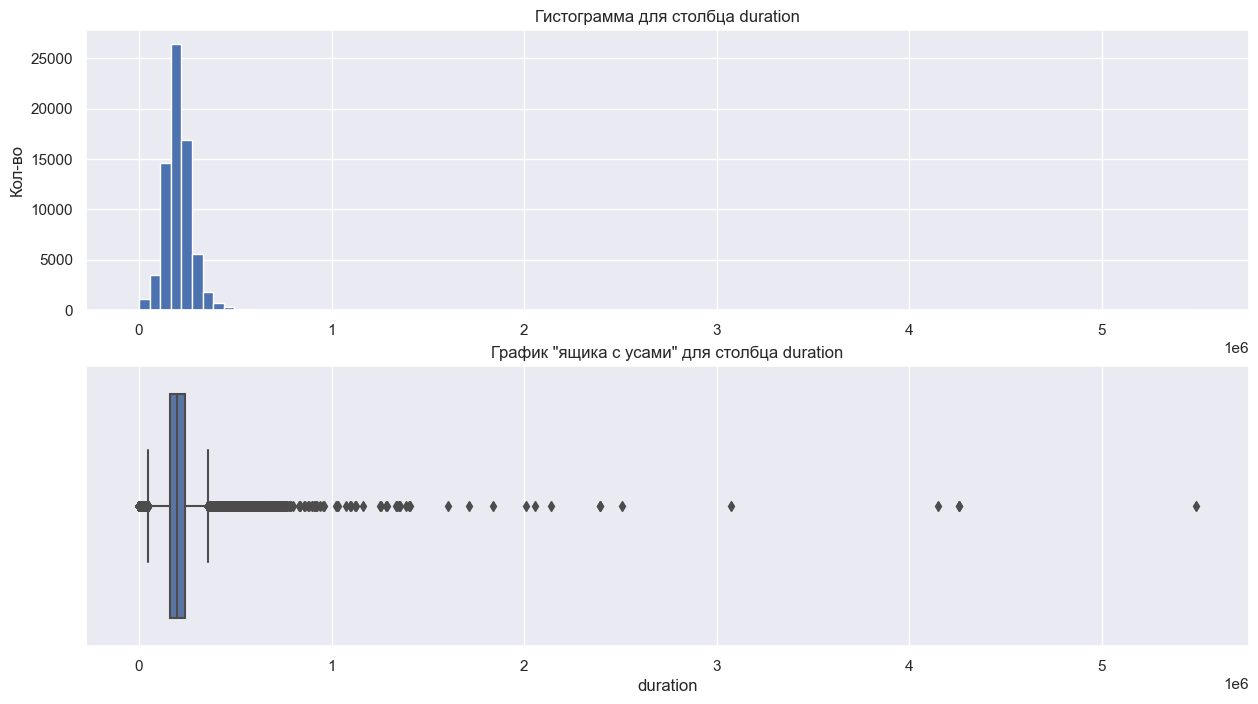

In [56]:
sns.set()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axes[0].hist(df_meta.loc[:, "duration"], bins=100)
axes[0].set_title(f"Гистограмма для столбца duration")
axes[0].set_ylabel("Кол-во")

sns.boxplot(x=df_meta.loc[:, "duration"], ax=axes[1])
axes[1].set_title(f'График "ящика с усами" для столбца duration')
print();

Наблюдаются аномальные знаечения по длительности трека. Необходимо будет удалить данные выбросы

Посмотрим как распределны в столбце dttm

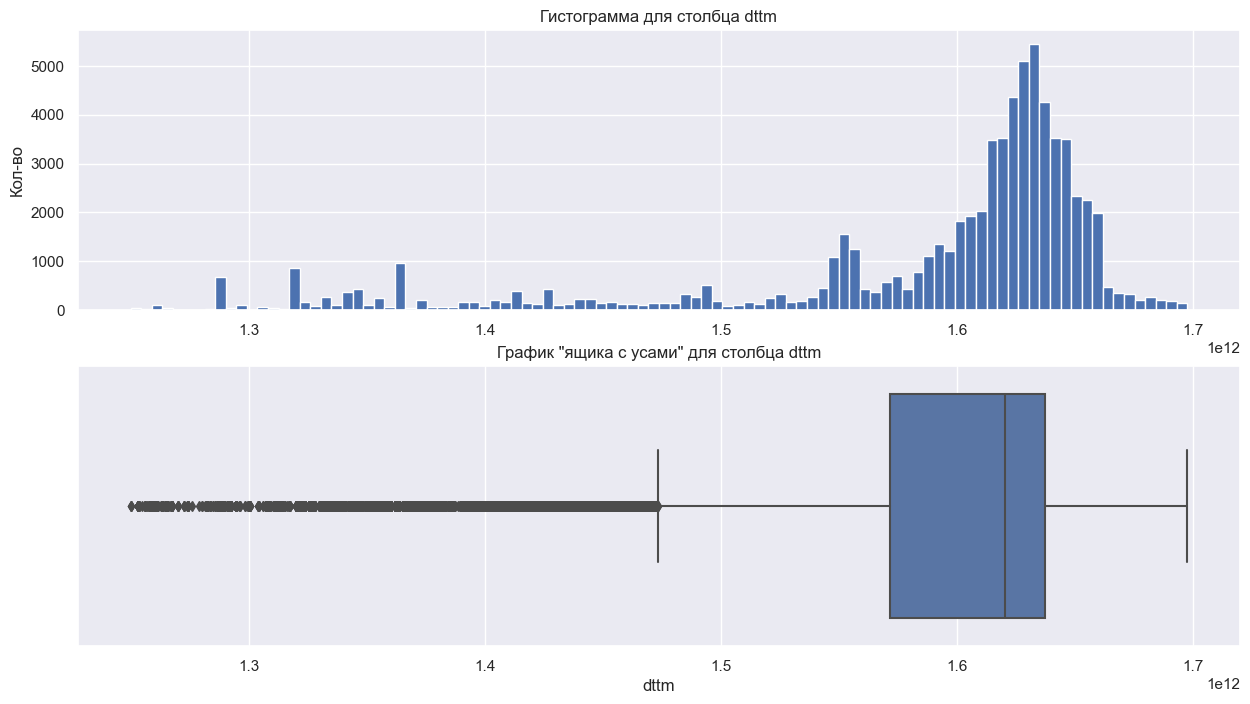

In [57]:
sns.set()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axes[0].hist(df_meta.loc[:, "dttm"], bins=100)
axes[0].set_title(f"Гистограмма для столбца dttm")
axes[0].set_ylabel("Кол-во")

sns.boxplot(x=df_meta.loc[:, "dttm"], ax=axes[1])
axes[1].set_title(f'График "ящика с усами" для столбца dttm')
print();

Наблюдается, что есть участок между 1,5*10^12 и 1,7*10^12, где большая часть данных представлена за определенный период времени. Вероятно это каверы. и бум их популярност ипришелся на определенный период. Провериv данную гипотезу. Но после обработки данных.

#### **Выводы по перому пункту:**
Были изучены три предоставленных набора данных:

1. covers.json

- Всего в таблице 71597 строк и 3 столбца. 
- Все столбцы соотеветсвуют заявленным типам данным.
- Пропуски присутсвуют в original_track_id
- в track_id все значения уникальны
- В столбце original_track_id(уникальный идентификатор исходного трека) присутсвует большое кол-во пропусков.
- наблюдается несбаласированность классов.



2. lyrics.json

- Всего в таблице 11414 строк и 3 столбца. 
- Все столбцы соотеветсвуют заявленным типам данным.
- Пропуски отсуствуют в таблицах.
- Текст требует предобработки и приведение к необходиому виду для дальнейшего обучения.Стоит учесть, текст представлен на разных языках
- Во всех столбцах присутсвуют дубликаты. В дальнейшем предлагется удалить строки с дубликатами в столбце track_id и удалить столбец lyricId.

Замечено, что данных с информация о тексте трека меньше, чем нам наш датафрем covers.json и meta.json, поэтому необходимо будет выполнить дополнительный поиск данных о треках.


3. meta.json

- Всего в таблице 71769 строк и 7 столбцов. 
- Не все столбцы соотеветсвуют заявленным типам данным.Так из столбца dttm неоходимо будет поулчить информацию о день/месяц/год появлении информации о треке 
- На основании duration предлагается создать новый столбцев также длительности трека, но в минутах. на данной этапе данные даны для миллисикундах и неудобны для для оценки. наблюдаюются аномальные выбросы. необходимо будет их удалить
- Во всех столбцах присутсвует хотя бы один пропуск. Наибольшее кол-во пропусков в столбце language. Далее идет по пропускам isrc. Из-за невозможности восстановить данный идентификатор для трека необходимо удалить строки с пропусками в столбце.
- изучены жанры и выделены те треки, которые не подходят для дальнейшего обучения


## 2. Предобработка данных 

#### Столбец genres.

**Удаление строк с треками жанров, которые не подходят**

In [58]:
df_meta.shape

(71283, 7)

In [59]:
# распаковываем списки жанров в строки
df_meta['genres'] = df_meta['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df_meta.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,DANCE,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,ELECTRONICS,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,FOLK LATINFOLK,260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,FOLK LATINFOLK,190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,FOLK LATINFOLK,203000.0


In [60]:
df_meta = df_meta[~df_meta['genres'].str.upper().str.contains('|'.join(genres_to_remove))]

df_meta.shape

(67976, 7)

####  Столбец dttm. Приведение к нужному типу данных

In [61]:
# преобразуем формат признака даты
df_meta['dttm'] = pd.to_datetime(df_meta['dttm'], unit='ms')
df_meta.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,DANCE,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,ELECTRONICS,362260.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,FOLK LATINFOLK,260000.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,FOLK LATINFOLK,190000.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,FOLK LATINFOLK,203000.0


In [62]:
# посмотрим на распределение данных
df_meta.dttm.describe()

count    67976                        
mean     2020-03-24 18:12:05.952218624
min      2009-08-10 17:32:06          
25%      2019-11-22 20:11:39          
50%      2021-05-13 21:00:00          
75%      2021-11-22 06:55:49.249999872
max      2023-10-18 21:00:00          
Name: dttm, dtype: object

Данные о первых датах появления информации о треках даны за период (2009-08-10:2023-10-18)

#### Столбец duration. Фильтрация данных

In [63]:
# длительность 0 минут
df_meta[df_meta['duration'] == 0]['duration'].count() 

333

In [64]:
# длительность меньше 30 секунд
df_meta[df_meta['duration'] < 30000]['duration'].count()

627

In [65]:
# длительность больше 10 минут
df_meta[df_meta['duration'] > 600000]['duration'].count()

185

In [66]:
med_diration = df_meta['duration'].median()
print('Медианное значение длительности трека:', med_diration/1000/60, 'минут')

Медианное значение длительности трека: 3.3405 минут


In [67]:
df_meta = df_meta[(df_meta['duration'] >= 30000) & (df_meta['duration'] <= 600000)]

In [68]:
df_meta.shape

(67164, 7)

#### Удаление дубликатов в таблице lyrics.json в столбце track_id

In [69]:
# удаляем дубликаты track_id
df_lyrics.drop_duplicates(subset='track_id', keep='first', inplace=True)

In [70]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10277 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   10277 non-null  object
 1   text      10277 non-null  object
 2   track_id  10277 non-null  object
dtypes: object(3)
memory usage: 321.2+ KB


In [71]:
print('Cколько строк быо удалено всего:', ((11414 - df_lyrics.shape[0])/11414)*100, '%')

Cколько строк быо удалено всего: 9.961450849833538 %


#### Объединение таблиц covers.json, lyrics.json, meta.json

In [72]:
df = df_covers.merge(df_meta, how='left', on="track_id")

In [73]:
df = df.merge(df_lyrics, how='left', on="track_id")

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  4821 non-null   object        
 1   track_id           71597 non-null  object        
 2   track_remake_type  71597 non-null  object        
 3   dttm               66999 non-null  datetime64[ns]
 4   title              66999 non-null  object        
 5   language           20062 non-null  object        
 6   isrc               66999 non-null  object        
 7   genres             66999 non-null  object        
 8   duration           66999 non-null  float64       
 9   lyricId            10123 non-null  object        
 10  text               10123 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.0+ MB


In [75]:
df.to_csv('df_for_parsing.csv', sep='\t')

#### Получение дополнительной информации по трекам (парсинг данных)

Был испробован парсинг данных на MusicBrainz(parsing_track_info.ipynb) и с использованием Selenium и публичных API (остановились на парсинге метаданных со Spotify API). C помощью данных ресурсов получали информацию о исполнителе и год реализа песни.
MusicBrainz не подошел, так как найдено мало полезных данных(около 3000). В итоге лучше подошел поиск через Spotify. \
Загрузим данные:

In [76]:
try:
    df_parsing = pd.read_csv('parsing.csv', sep='\t')
except:
    print(
        "Один или несколько файлов не найдены. Проверьте путь до файла(ов) или само наличие датафрейма(ов) на компьютере"
    )

In [77]:
df_parsing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9663 entries, 0 to 9662
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         9663 non-null   int64  
 1   original_track_id  2930 non-null   object 
 2   track_id           9663 non-null   object 
 3   track_remake_type  9663 non-null   object 
 4   lyricId            9663 non-null   object 
 5   text               9663 non-null   object 
 6   dttm               9663 non-null   object 
 7   title              9663 non-null   object 
 8   language           6020 non-null   object 
 9   isrc               9663 non-null   object 
 10  genres             9605 non-null   object 
 11  duration           9663 non-null   float64
 12  artist             8282 non-null   object 
 13  release_date       8282 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.0+ MB


Также в тетрадке parsing_lyrics.ipynb на базе genius реализован шаблон поиска текста для песен. Но так как поиск песен ведется на основании  исполнителя и его песни, то поиском не пришлось воспользоваться.

In [78]:
df_parsing = df_parsing.drop(['Unnamed: 0'],axis=1)

По некоторым трекам информаия об артисте не нашлась. удалим данные пустые строки

In [79]:
df_parsing.dropna(subset=['artist'],inplace=True)

In [80]:
df_parsing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8282 entries, 0 to 9662
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  2751 non-null   object 
 1   track_id           8282 non-null   object 
 2   track_remake_type  8282 non-null   object 
 3   lyricId            8282 non-null   object 
 4   text               8282 non-null   object 
 5   dttm               8282 non-null   object 
 6   title              8282 non-null   object 
 7   language           5507 non-null   object 
 8   isrc               8282 non-null   object 
 9   genres             8226 non-null   object 
 10  duration           8282 non-null   float64
 11  artist             8282 non-null   object 
 12  release_date       8282 non-null   object 
dtypes: float64(1), object(12)
memory usage: 905.8+ KB


Удалим с строки с пустой информацией о жанрах

In [81]:
df_parsing = df_parsing.dropna(subset=['genres']).reset_index().drop(['index'],axis=1)

In [82]:
df_parsing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  2751 non-null   object 
 1   track_id           8226 non-null   object 
 2   track_remake_type  8226 non-null   object 
 3   lyricId            8226 non-null   object 
 4   text               8226 non-null   object 
 5   dttm               8226 non-null   object 
 6   title              8226 non-null   object 
 7   language           5478 non-null   object 
 8   isrc               8226 non-null   object 
 9   genres             8226 non-null   object 
 10  duration           8226 non-null   float64
 11  artist             8226 non-null   object 
 12  release_date       8226 non-null   object 
dtypes: float64(1), object(12)
memory usage: 835.6+ KB


Заполним временно в original_track_id,language пустыне ячейки значением 'unknown'.

In [83]:
df_parsing['original_track_id'] = df_parsing['original_track_id'].fillna('unknown')

In [84]:
df_parsing['language'] = df_parsing['language'].fillna('unknown')

переведем dttm еще раз в нужный тип данных

In [85]:
df_parsing['dttm'] = pd.to_datetime(df_parsing['dttm'])

#### Добавления стобцов для анализа

#####  `dttm` - Выделим год когда о треке появилась первая информация

In [86]:
df_parsing['dttm_year'] = df_parsing['dttm'].apply(lambda x: x.year)

#####  Идентификатор `isrc` 

In [87]:
df_parsing['isrc_country_iso'] = df_parsing['isrc'].apply(lambda x: x[:2])
df_parsing['isrc_organization'] = df_parsing['isrc'].apply(lambda x: x[2:5])

In [88]:
for i in tqdm(df_parsing.index):
    x = int(df_parsing['isrc'][i][5:7])
    if x < 24:
        df_parsing.loc[i,'isrc_year'] = 2000 + x
    else:
        df_parsing.loc[i,'isrc_year'] = 1900 + x

100%|████████████████████████████████████| 8226/8226 [00:00<00:00, 11934.98it/s]


In [89]:
df_parsing['isrc_year'] = df_parsing['isrc_year'].astype('int')

#####   Выделим год из столбца `release_date` 

Дата реализа песни.

In [90]:
df_parsing['release_date_year'] = df_parsing['release_date'].apply(lambda x: int(x[0:4]))

#### Определение языка текста

In [91]:
my_lang = []
for i in tqdm(df_parsing['text']):
    temp = langid.classify(i)[0]
    my_lang.append(temp)

100%|██████████████████████████████████████| 8226/8226 [00:13<00:00, 629.61it/s]


Библиотека смогла определит язык для всех текстов

In [92]:
len(my_lang)

8226

In [93]:
provarka_lang = df_parsing[df_parsing['language'] != 'unknown']

In [94]:
lang_sravnenie =[]
for i in tqdm(provarka_lang.index):
    if provarka_lang.loc[i,'language'].lower() != my_lang[i]:
        lang_sravnenie.append(i)

100%|███████████████████████████████████| 5478/5478 [00:00<00:00, 140656.61it/s]


In [95]:
print('Найдено расхождений между языком исполнителя и языком текста',len(lang_sravnenie))

Найдено расхождений между языком исполнителя и языком текста 261


Проверим

In [96]:
my_lang[lang_sravnenie[0]]

'fi'

In [97]:
df_parsing.loc[lang_sravnenie[0]]

original_track_id    unknown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
track_id             fedc604da8b0f9af74b6cfc0fab2163c                                                                                                                                                                                                                                                  

как можно заметить указано, что исполнитель поет на английском, но песня на финском. Заменим значения в language на найденные нами

In [98]:
df_parsing['language'] = my_lang
df_parsing.head(1)

,original_track_id,track_id,track_remake_type,lyricId,text,dttm,title,language,isrc,genres,duration,artist,release_date,dttm_year,isrc_country_iso,isrc_organization,isrc_year,release_date_year
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,260f21d9f48e8de874a6e844159ddf28,"Left a good job in the city\nWorkin' for the man ev'ry night and day\nAnd I never lost one minute of sleepin'\nWorryin' 'bout the way things might have been\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on the river\n\nCleaned a lot of plates in Memphis\nPumped a lot of 'pane down in New Orleans\nBut I never saw the good side of a city\n'Til I hitched a ride on a riverboat queen\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on the river\n\nRollin', rollin', rollin' on the river\n\nIf you come down to the river\nBet you gonna find some people who live\nYou don't have to worry 'cause you have no money\nPeople on the river are happy to give\n\nBig wheel keep on turnin'\nProud Mary keep on burnin'\nRollin', rollin', rollin' on the river\nRollin', rollin', rollin' on the river\nRollin', rollin', rollin' on the river\nRollin', rollin', rollin' on",2009-11-11 21:00:00,Proud Mary,en,USFI86900049,ROCK ALLROCK,187220.0,Creedence Clearwater Revival,1969-01-05,2009,US,FI8,1969,1969


In [99]:
df_parsing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  8226 non-null   object        
 1   track_id           8226 non-null   object        
 2   track_remake_type  8226 non-null   object        
 3   lyricId            8226 non-null   object        
 4   text               8226 non-null   object        
 5   dttm               8226 non-null   datetime64[ns]
 6   title              8226 non-null   object        
 7   language           8226 non-null   object        
 8   isrc               8226 non-null   object        
 9   genres             8226 non-null   object        
 10  duration           8226 non-null   float64       
 11  artist             8226 non-null   object        
 12  release_date       8226 non-null   object        
 13  dttm_year          8226 non-null   int64         
 14  isrc_cou

#### **Выводы по второму пункту:**

- удалены строки с жанрами, которые не подходят
- столбец dttm. приведен к нужному типу данных
- выполнена фильтрация строк по duration (оставили треки с длительностью от 30 секнуд и до 10 минут)
- Удаление дубликатов в таблице lyrics.json в столбце track_id
- таблицы были объеденены в одну
- Получение дополнительной информации по трекам (парсинг данных по isrc). Выполнено  с использованием Selenium и публичных API (остановились на парсинге метаданных со Spotify API)
- выделен полезные данные из isrc
- выполнено определение языка текста

## 3.Исследовательский анализ данных

#### Трек с наибольшим кол-вом каверов среди оригиналов, которые известны

In [100]:
df_group_original_track_id = (
    df_parsing[df_parsing["track_remake_type"] != "ORIGINAL"]
    .groupby("original_track_id", as_index=False)["track_id"]
    .count()
    .sort_values(by="track_id", ascending=False)
)
df_group_original_track_id.head()

,original_track_id,track_id
124,unknown,5475
117,f3e5e9db509f9b6f6d93b9c38e4e1324,27
36,53a04991308c2cc9179fdd401fea83a3,19
107,deb9b9598176a0bab1212d430b10bd04,17
60,8e0235cf2a39eacc4c78885ca7dd4de3,14


In [101]:
df_group_original_track_id = (
    df_group_original_track_id[df_group_original_track_id["track_id"] > 1][1:]
    .reset_index()
    .drop("index", axis=1)
)

In [102]:
for i in range(len(df_group_original_track_id)):
    if df_group_original_track_id.loc[i, "original_track_id"] in list(df_parsing['track_id']):
        df_group_original_track_id.loc[i, "artist"] = list(
            df_parsing[
                df_parsing["track_id"]
                == df_group_original_track_id.loc[i, "original_track_id"]
            ]["artist"]
        )[0]
        df_group_original_track_id.loc[i, "title"] = list(
            df_parsing[
                df_parsing["track_id"]
                == df_group_original_track_id.loc[i, "original_track_id"]
            ]["title"]
        )[0]
    else:
        df_group_original_track_id.loc[i, "artist"] = 'unknown'
        df_group_original_track_id.loc[i, "title"] = 'unknown'


In [103]:
df_group_original_track_id

,original_track_id,track_id,artist,title
0,f3e5e9db509f9b6f6d93b9c38e4e1324,27,Chris Isaak,Wicked Game
1,53a04991308c2cc9179fdd401fea83a3,19,unknown,unknown
2,deb9b9598176a0bab1212d430b10bd04,17,"Eurythmics, Annie Lennox, Dave Stewart",Sweet Dreams (Are Made of This)
3,8e0235cf2a39eacc4c78885ca7dd4de3,14,unknown,unknown
4,0fcb82fec458a0993f848200548eaaa0,13,unknown,unknown
5,17a163f6ab3de102b49599f5577866fc,13,Nirvana,Smells Like Teen Spirit
6,cfcd208495d565ef66e7dff9f98764da,11,unknown,unknown
7,eeb69a3cb92300456b6a5f4162093851,11,Creedence Clearwater Revival,Proud Mary
8,b9213d37c37deffe8b8af0dac5d0c3c4,10,Robert Knight,Everlasting Love
9,9050384cce6c221c39d6e25d02561612,5,Michael Jackson,Smooth Criminal


Как можно видеть многие original_track_id отсуствует в track_id. Столбец original_track_id в таблице df_parsing нужно будет удалить. он малоинформативен. 

#### Исследование исполнителей

#ТОП-10:artist


,artist,count
443,Boyce Avenue,236
1336,Hitomi Flor,100
3157,Various Artists,62
3328,m19 [kei],47
729,Dance Fruits Music,33
3311,fenekot,29
3172,Victor Herbas,29
1524,Jennel Garcia,28
2297,Northern Kings,26
1647,KHS,25


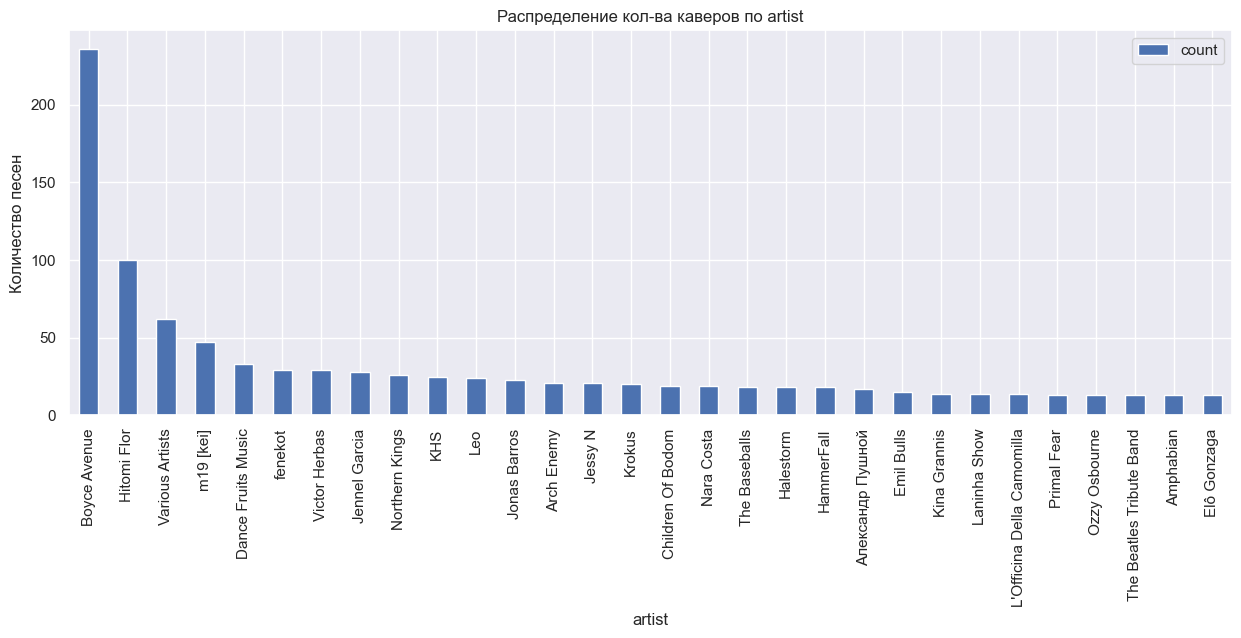

In [104]:
plot_info_cover('artist',df_parsing)

#ТОП-10:artist


,artist,count
133,Artik & Asti,21
212,Boyce Avenue,19
685,MACAN,18
629,Lesha Svik,16
1220,VERBEE,16
889,NЮ,16
732,Mari Kraimbrery,13
1157,The Limba,13
595,Korol i Shut,13
1422,МОТ,13


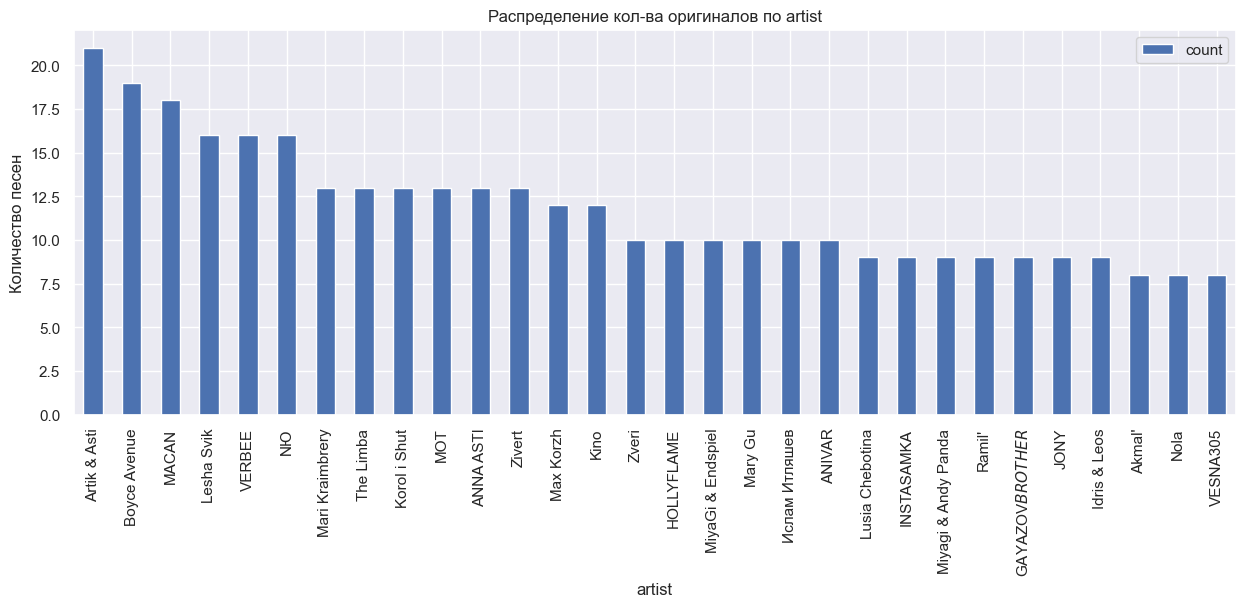

In [105]:
plot_info_original('artist',df_parsing)

#ТОП-10:artist


,artist,count
642,Boyce Avenue,255
1764,Hitomi Flor,100
4294,Various Artists,62
4545,m19 [kei],47
998,Dance Fruits Music,33
4517,fenekot,29
4309,Victor Herbas,29
2023,Jennel Garcia,28
3113,Northern Kings,26
2166,KHS,25


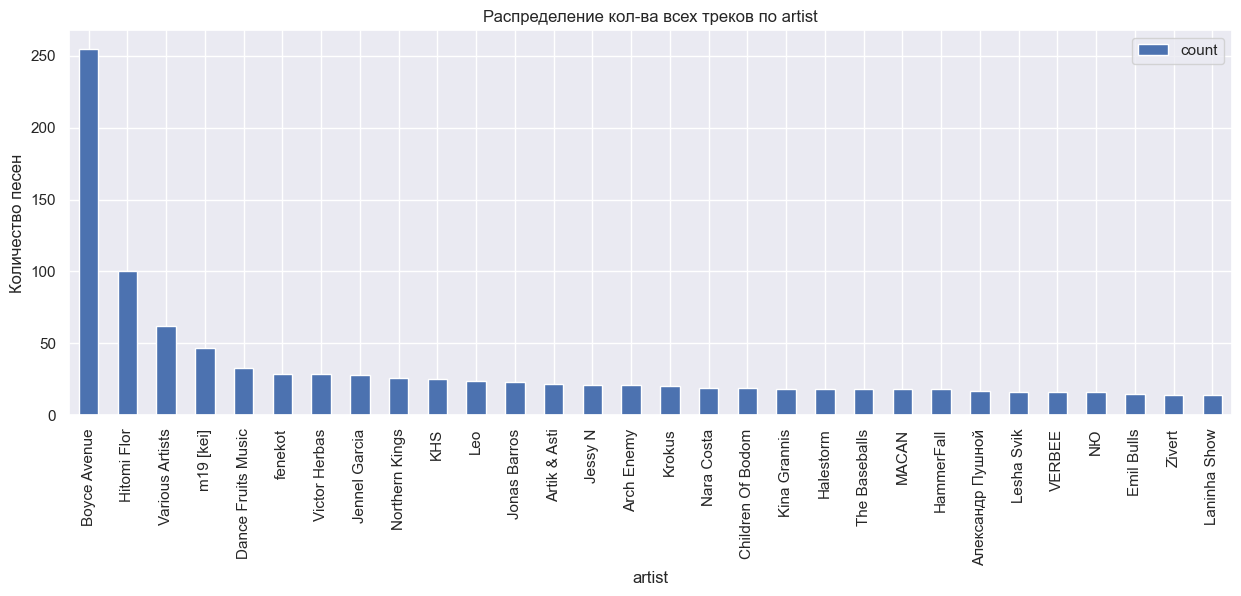

In [106]:
plot_info_all('artist',df_parsing)

#### Исследование треков

#ТОП-10:title


,title,count
4044,Wicked Game,31
3722,Toxic,23
3264,Smells Like Teen Spirit,18
3441,Sweet Dreams,14
437,Blinding Lights,14
2852,Proud Mary,12
4194,Zombie,11
3351,Stand by Me,10
740,Creep,10
1096,Everlasting Love,10


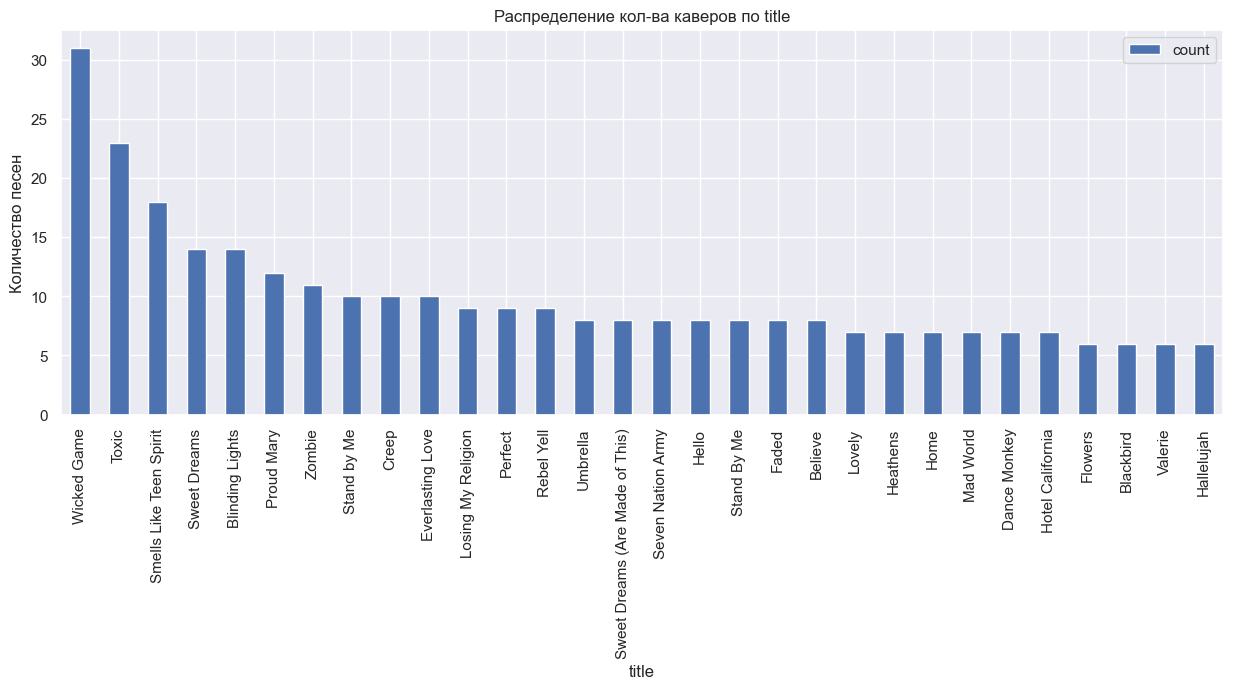

In [107]:
plot_info_cover('title',df_parsing)

#ТОП-10:title


,title,count
715,Smooth Criminal,8
1692,Новогодняя,6
2100,Танцуй,4
681,Scars,3
1886,Привет,3
501,Malibu,3
1874,Последний поцелуй,3
2075,Стреляй,3
1313,Зацепила,3
2028,Скандал,3


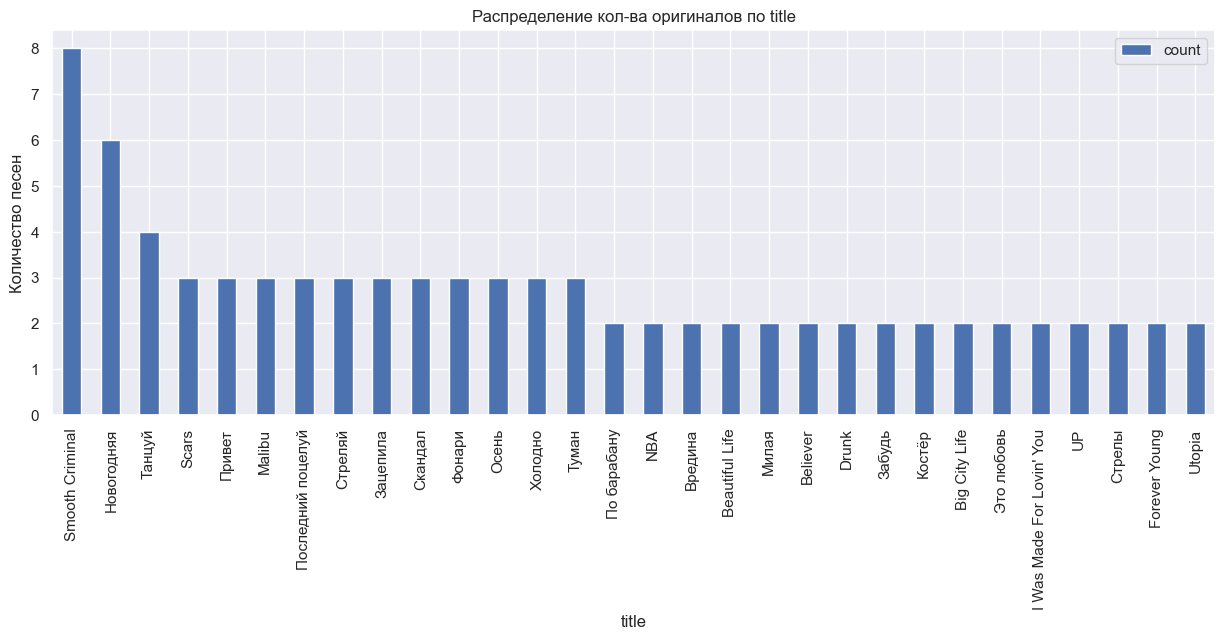

In [108]:
plot_info_original('title',df_parsing)

#ТОП-10:title


,title,count
4763,Wicked Game,32
4392,Toxic,24
3838,Smells Like Teen Spirit,19
528,Blinding Lights,16
3841,Smooth Criminal,14
4049,Sweet Dreams,14
3364,Proud Mary,13
4937,Zombie,12
1305,Everlasting Love,12
3940,Stand by Me,10


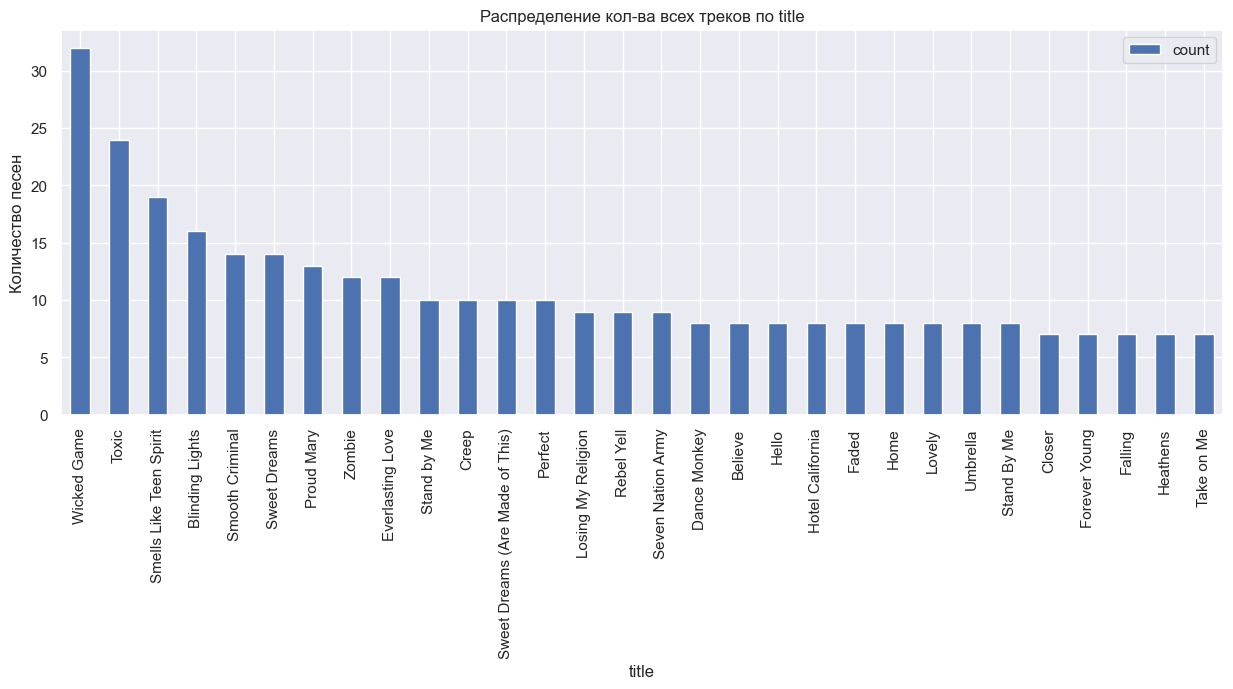

In [109]:
plot_info_all('title',df_parsing)

#### Исследование по жанрам

#ТОП-10:genres


,genres,count
84,POP,1182
116,ROCK ALLROCK,802
23,DANCE,425
53,FOLK LATINFOLK,398
31,ELECTRONICS,305
5,ALTERNATIVE,297
57,FOREIGNBARD BARD,153
20,CLASSICMETAL METAL,145
63,INDIE,131
70,METAL,124


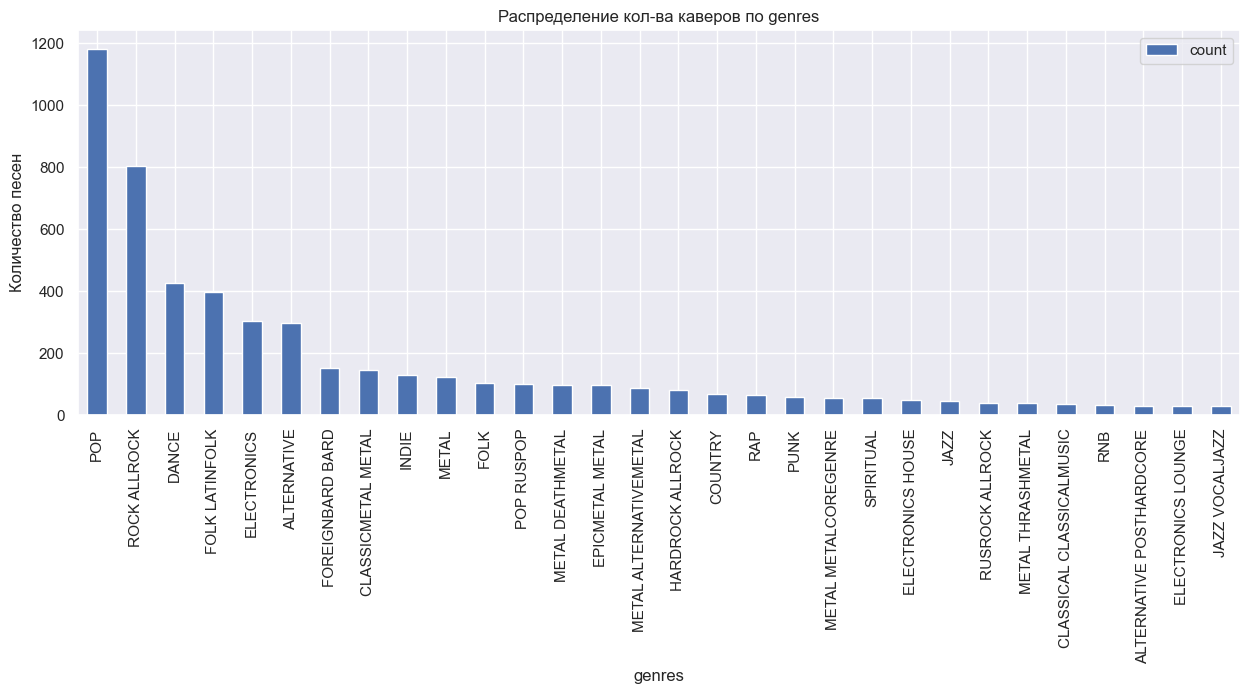

In [110]:
plot_info_cover('genres',df_parsing)

#ТОП-10:genres


,genres,count
54,POP RUSPOP,905
69,RUSRAP RAP,460
8,DANCE,269
36,POP,196
70,RUSROCK ALLROCK,82
13,ELECTRONICS,77
58,RAP,48
60,ROCK ALLROCK,47
2,ALTERNATIVE,39
67,RUSESTRADA ESTRADA,32


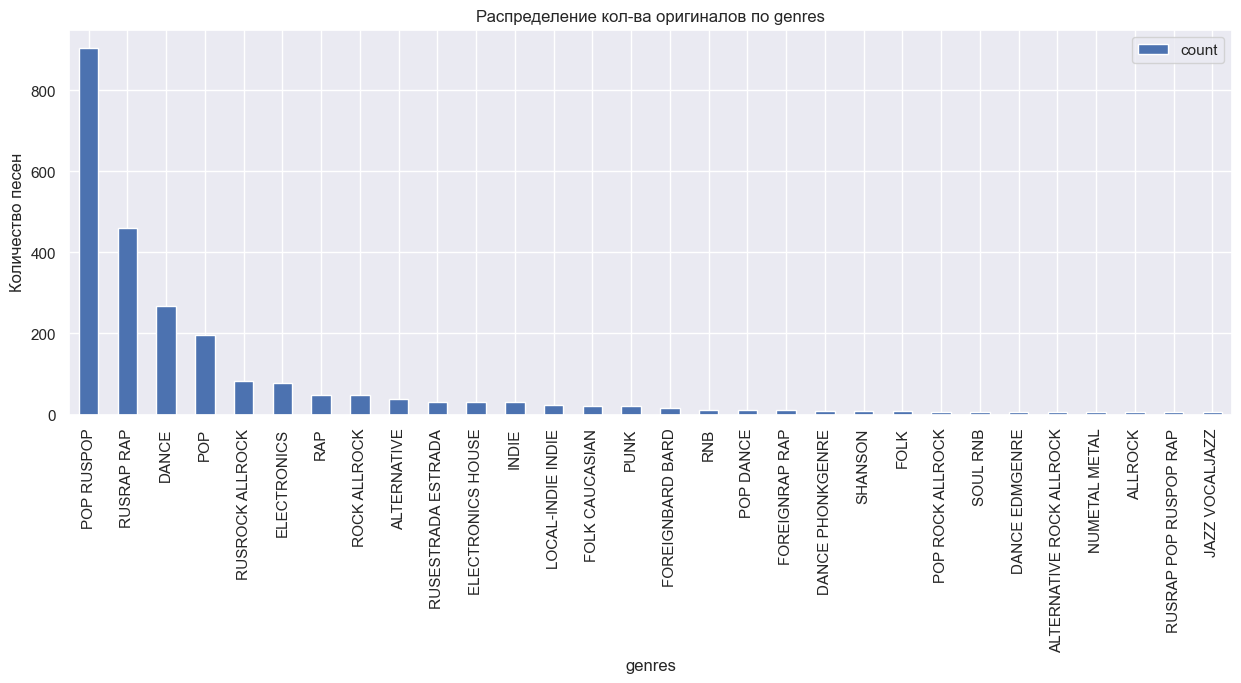

In [111]:
plot_info_original('genres',df_parsing)

#ТОП-10:genres


,genres,count
86,POP,1378
118,POP RUSPOP,1007
128,ROCK ALLROCK,849
24,DANCE,694
140,RUSRAP RAP,474
55,FOLK LATINFOLK,402
32,ELECTRONICS,382
5,ALTERNATIVE,336
59,FOREIGNBARD BARD,169
65,INDIE,161


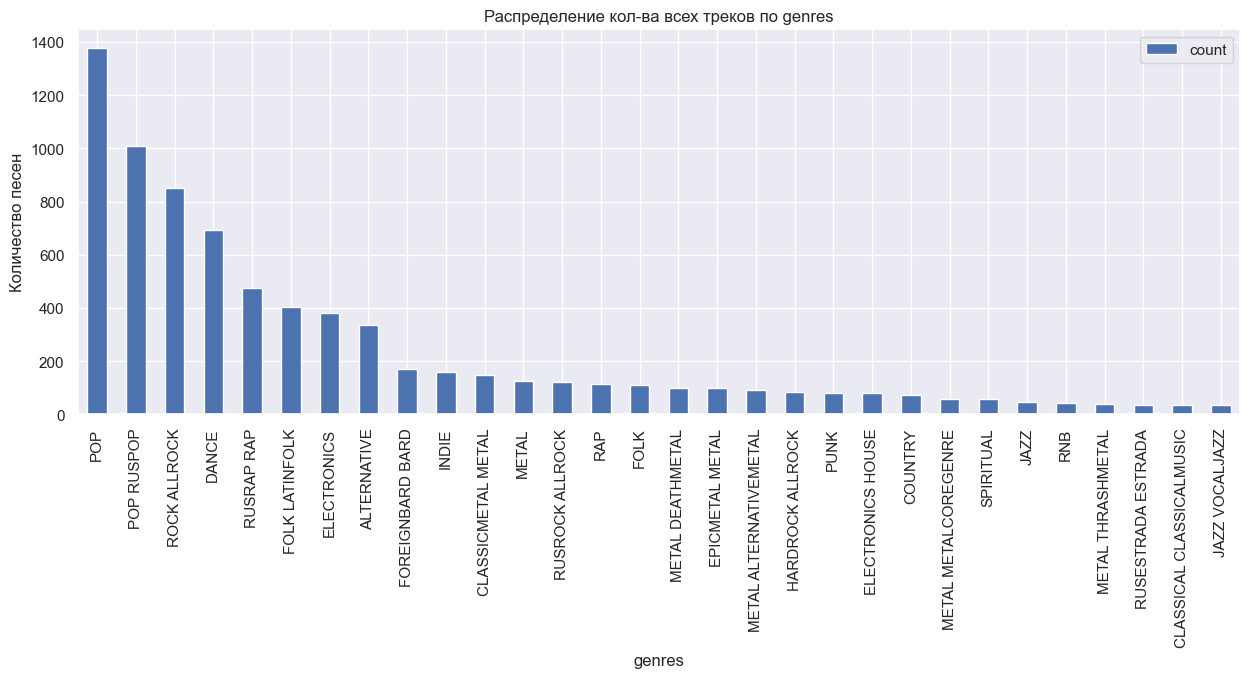

In [112]:
plot_info_all('genres',df_parsing)

#### Исследование по организациям ISRC

#ТОП-10:isrc_organization


,isrc_organization,count
714,M95,240
908,UM7,143
219,A56,130
789,PJ3,128
599,GWX,100
211,A37,91
867,T0G,90
394,B42,84
635,HZ5,82
160,7VG,80


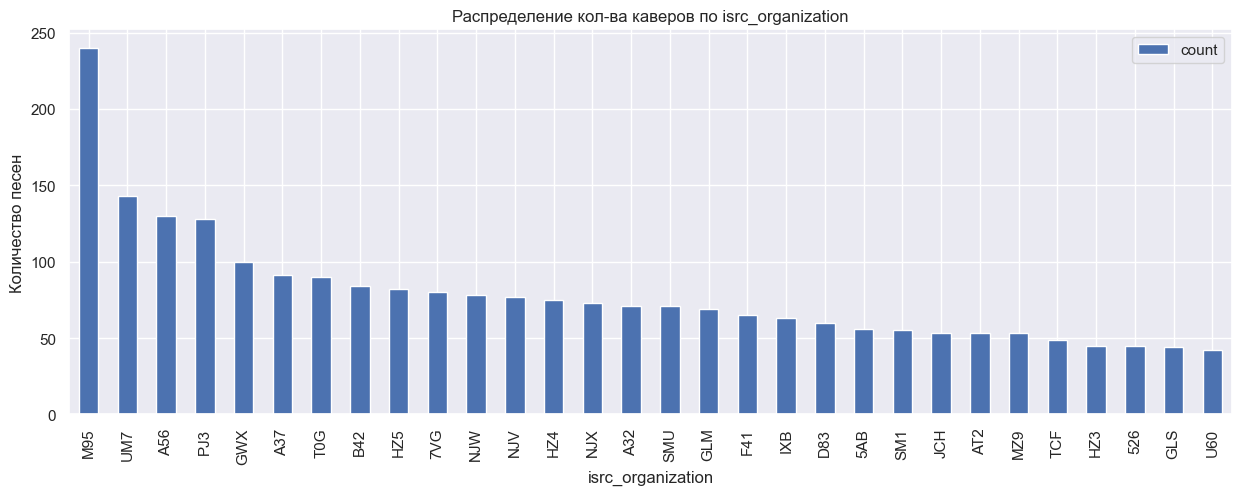

In [113]:
plot_info_cover('isrc_organization',df_parsing)

#ТОП-10:isrc_organization


,isrc_organization,count
71,A1D,238
158,B42,205
309,RUS,144
76,A32,112
329,UM7,90
83,A58,84
372,YT7,66
35,59R,49
84,A59,47
359,X45,46


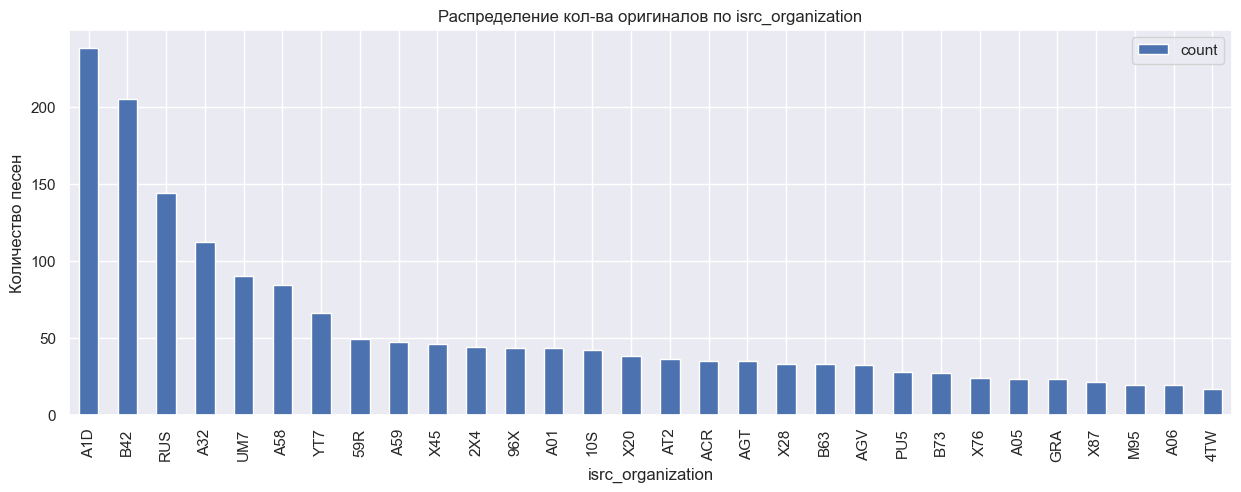

In [114]:
plot_info_original('isrc_organization',df_parsing)

#ТОП-10:isrc_organization


,isrc_organization,count
448,B42,289
231,A1D,270
805,M95,259
1023,UM7,233
242,A32,183
945,RUS,147
254,A56,133
888,PJ3,128
255,A58,101
673,GWX,100


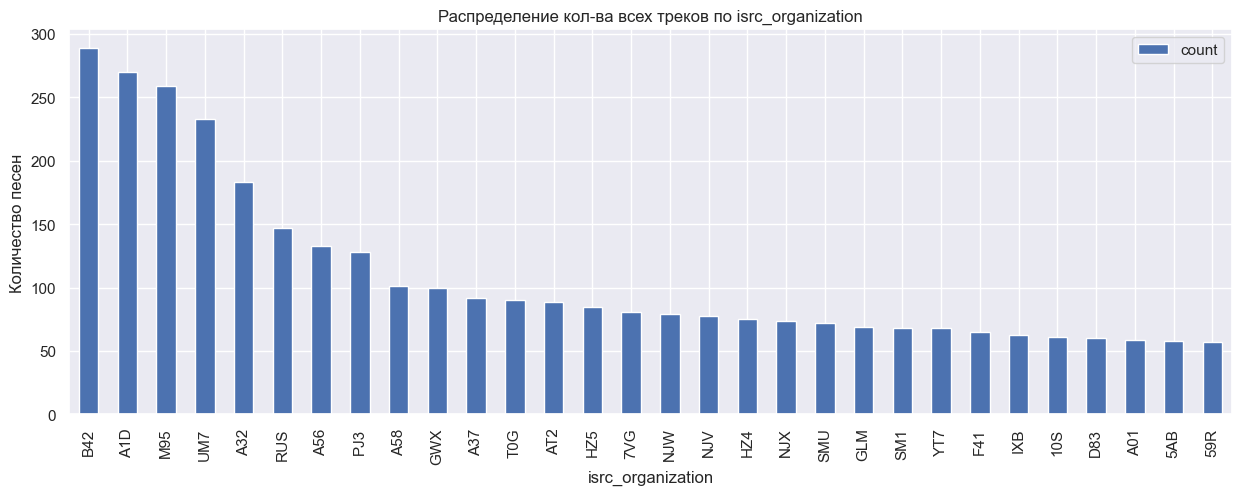

In [115]:
plot_info_all('isrc_organization',df_parsing)

#### Исследование по стране регистрации трека

#ТОП-10:isrc_country_iso


,isrc_country_iso,count
60,US,1485
47,QZ,1296
24,GB,414
17,DE,403
46,QM,284
2,AR,232
53,TC,204
50,RU,203
23,FR,173
39,NL,138


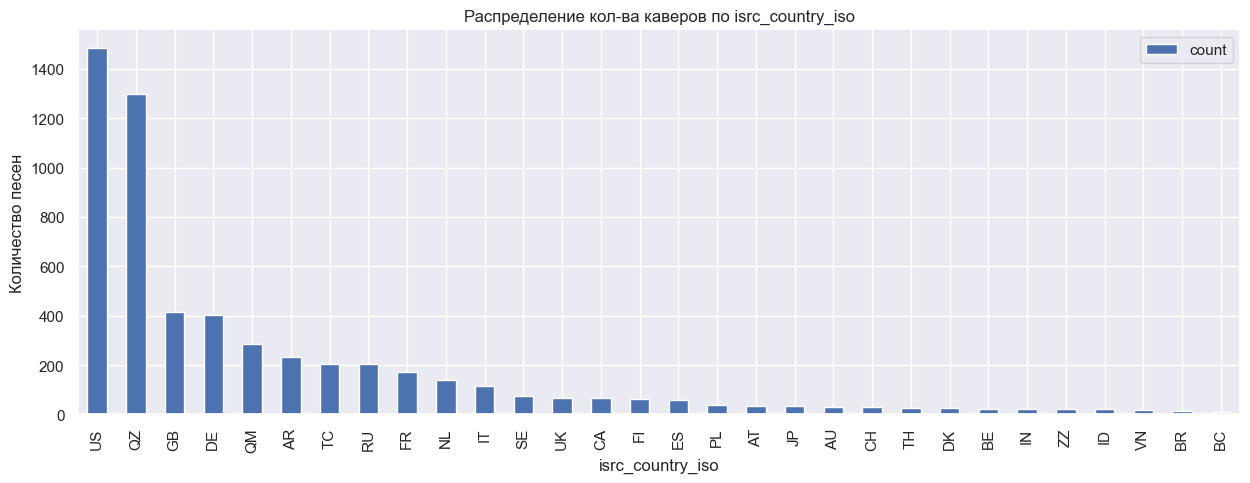

In [116]:
plot_info_cover('isrc_country_iso',df_parsing)

#ТОП-10:isrc_country_iso


,isrc_country_iso,count
32,RU,945
16,FR,398
38,US,223
29,QM,148
34,SM,144
10,DE,140
18,GB,89
11,DG,77
30,QZ,77
35,TC,68


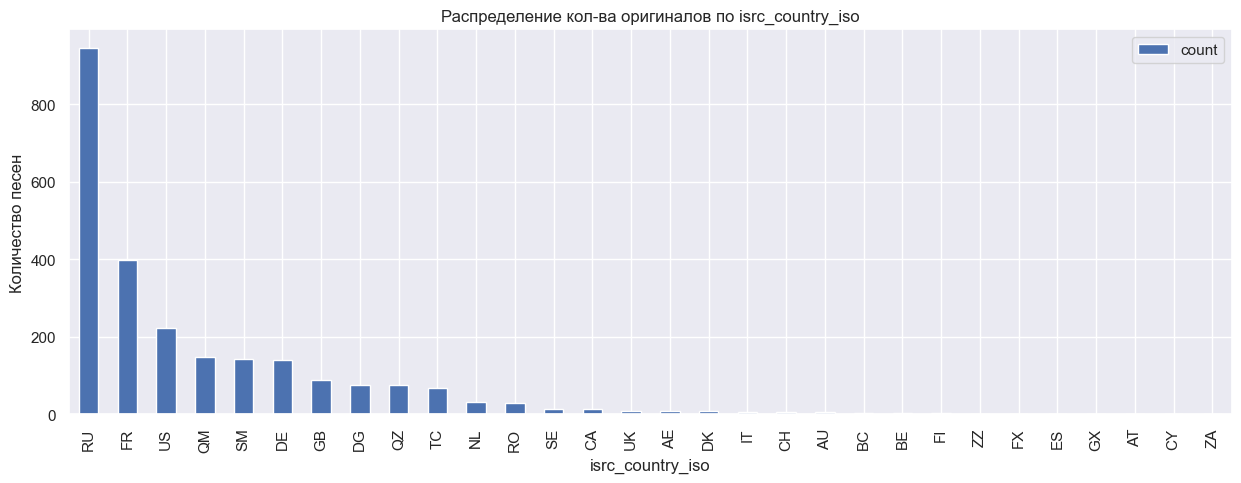

In [117]:
plot_info_original('isrc_country_iso',df_parsing)

#ТОП-10:isrc_country_iso


,isrc_country_iso,count
66,US,1708
53,QZ,1373
56,RU,1148
26,FR,571
19,DE,543
28,GB,503
52,QM,432
59,TC,272
2,AR,232
45,NL,170


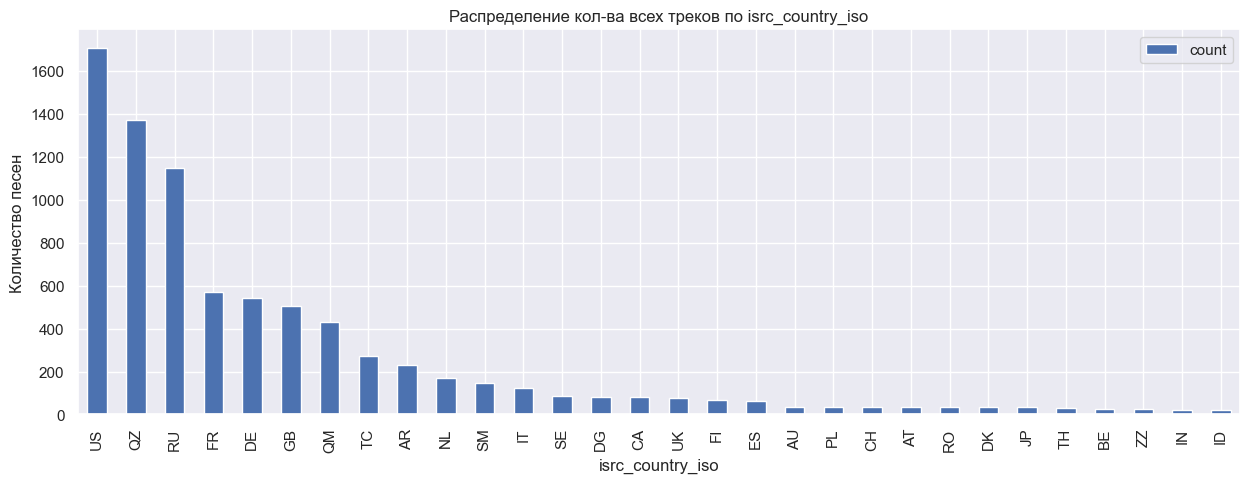

In [118]:
plot_info_all('isrc_country_iso',df_parsing)

Выполним  расшифровку кода стран

In [119]:
list_iso_country = list(df_parsing.loc[:, "isrc_country_iso"].sort_values().unique())

In [120]:
print("Расшифровка индетификатора страны:")
iso_abbreviatura = []
iso_name_country = []
name_country = 0
for value in list_iso_country:
    iso_abbreviatura.append(value)
    try:
        name_country = countries.get(value)[0]
        iso_name_country.append(name_country)
    except:
        if value in ['QM','CP','DG']:
            iso_name_country.append(countries.get('US')[0])
        elif value in ['ZZ']:
            iso_name_country.append("ISRC")
        else:
            iso_name_country.append("unknown")
data_country = pd.DataFrame(
    {"abbreviatura": iso_abbreviatura, "country": iso_name_country}
)
data_country

Расшифровка индетификатора страны:


,abbreviatura,country
0,AE,United Arab Emirates
1,AL,Albania
2,AR,Argentina
3,AT,Austria
4,AU,Australia
5,BA,Bosnia and Herzegovina
6,BC,unknown
7,BE,Belgium
8,BK,unknown
9,BM,Bermuda


Посмотрим коды стран, которых не смогли определить 

In [121]:
data_country[data_country['country'] == 'unknown']

,abbreviatura,country
6,BC,unknown
8,BK,unknown
11,BX,unknown
13,CB,unknown
27,FX,unknown
31,GX,unknown
53,QZ,unknown
64,UK,unknown
65,UP,unknown


Посчитаем кол-во строк с неизвестными кодами стран

In [122]:
# запомним список кодов стран с неизвстной страной
list_unknown_country = list(
    data_country[data_country["country"] == "unknown"]["abbreviatura"]
)

In [123]:
list_unknown_country

['BC', 'BK', 'BX', 'CB', 'FX', 'GX', 'QZ', 'UK', 'UP']

In [124]:
count_unknown_country = []
for value in list_unknown_country:
    count_unknown_country.append(
        df_parsing[df_parsing["isrc"].str.startswith(value)]["isrc"].count()
    )


In [125]:
data_count_unknown_country = pd.DataFrame(
    {"abbreviatura": list_unknown_country, "count_rows": count_unknown_country}
)

In [126]:
data_count_unknown_country.sort_values(by='count_rows', ascending=False)

,abbreviatura,count_rows
6,QZ,1373
7,UK,77
0,BC,16
2,BX,10
5,GX,6
4,FX,2
1,BK,1
3,CB,1
8,UP,1


In [127]:
print(
    "Всего строк в датасете с неизвестными странами:",
    data_count_unknown_country["count_rows"].sum()/len(df_parsing)*100,'%'
)

Всего строк в датасете с неизвестными странами: 18.076829564794554 %


Вероятно данные коды зарезервированы под конкртеные страны.

#### Исследование связи годов по стобцам release_date_year,dttm_year,isrc_year

In [128]:
year_sravnenie = []
for i in tqdm(df_parsing.index):
    if df_parsing.loc[i, "dttm_year"] != df_parsing.loc[i, "isrc_year"]:
        year_sravnenie.append(i)


100%|████████████████████████████████████| 8226/8226 [00:00<00:00, 66203.61it/s]


In [129]:
print('Кол-во строк с нединаковымим датами:',len(year_sravnenie))
print('Процент строк с нединаковымим датами:',len(year_sravnenie)/len(df_parsing)*100,'%')

Кол-во строк с нединаковымим датами: 3743
Процент строк с нединаковымим датами: 45.50206661804036 %


In [130]:
df_parsing.loc[year_sravnenie[0], ["dttm_year", "isrc_year", "release_date_year"]]

dttm_year            2009
isrc_year            1969
release_date_year    1969
Name: 0, dtype: object

In [131]:
year_sravnenie_2 =[]
for i in tqdm(df_parsing.index):
    if df_parsing.loc[i,'release_date_year'] != df_parsing.loc[i,'isrc_year']:
        year_sravnenie_2.append(i)

100%|████████████████████████████████████| 8226/8226 [00:00<00:00, 72594.03it/s]


In [132]:
print('Кол-во строк с нединаковымим датами:',len(year_sravnenie_2))
print('Процент строк с нединаковымим датами:',len(year_sravnenie_2)/len(df_parsing)*100,'%')

Кол-во строк с нединаковымим датами: 2541
Процент строк с нединаковымим датами: 30.88986141502553 %


In [133]:
df_parsing.loc[year_sravnenie_2[0],['dttm_year','isrc_year','release_date_year']]

dttm_year            2009
isrc_year            1969
release_date_year    1976
Name: 1, dtype: object

In [134]:
year_sravnenie_3 = []
for i in tqdm(df_parsing.index):
    if (
        df_parsing.loc[i, "release_date_year"]
        != df_parsing.loc[i, "isrc_year"]
        != df_parsing.loc[i, "dttm_year"]
    ):
        year_sravnenie_3.append(i)


100%|████████████████████████████████████| 8226/8226 [00:00<00:00, 64921.39it/s]


In [135]:
print('Кол-во строк с нединаковымим датами:',len(year_sravnenie_3))
print('Процент строк с нединаковымим датами:',len(year_sravnenie_3)/len(df_parsing)*100,'%')

Кол-во строк с нединаковымим датами: 2197
Процент строк с нединаковымим датами: 26.70799902747386 %


Полученный 

In [136]:
df_parsing.loc[year_sravnenie_3[20],['dttm_year','isrc_year','release_date_year']]

dttm_year            2010
isrc_year            2004
release_date_year    2021
Name: 44, dtype: object

Года в dttm_year практически на половину совпадают с isrc_year.Данные слишком сильно связаны. Но так как инфомрация про трек наиболее точная хранится в идентификаторе isrc, то предлагается удалить столбцы dttm_year и dttm. ТАкже заечено, что
Свзяь между isrc_year и release_date_year еще больше практичеси 70% данных сопадает. ТАкже удалим стобец release_date_year

#### Исследование кол-во треков по годам

In [137]:
value = 'isrc_year'
data = df_parsing

#ТОП-10:isrc_year


,isrc_year,count
59,2021,1242
58,2020,767
60,2022,516
57,2019,352
56,2018,308
55,2017,246
54,2016,225
44,2006,197
53,2015,193
48,2010,163


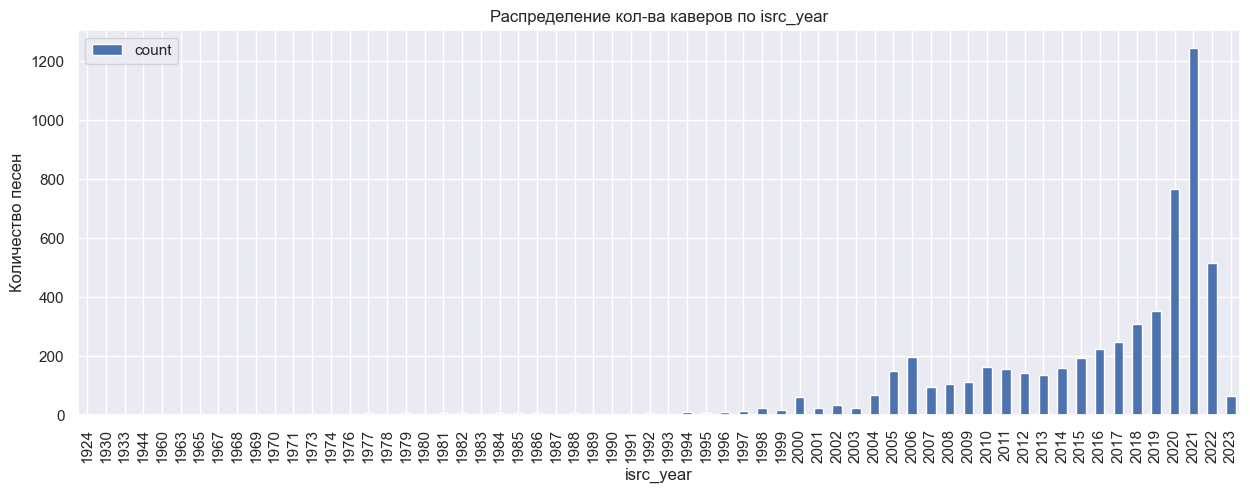

In [138]:
df_group_year_cover = (
    data[data["track_remake_type"] != "ORIGINAL"]
    .groupby(value, as_index=False)["track_id"]
    .count()
    .rename(columns={'track_id': 'count'})
)
print(f'#ТОП-10:{value}')
display(df_group_year_cover.sort_values(by="count", ascending=False).head(10))#ТОП-10

print()
df_group_year_cover.plot(value,'count',kind='bar', figsize=(15,5), grid = True)
plt.title(f'Распределение кол-ва каверов по {value}')
plt.xlabel(value)
plt.ylabel('Количество песен')
plt.show()

#ТОП-10:isrc_year


,isrc_year,count
45,2022,549
44,2021,455
46,2023,254
43,2020,250
42,2019,169
23,2000,154
40,2017,100
41,2018,86
39,2016,74
38,2015,64


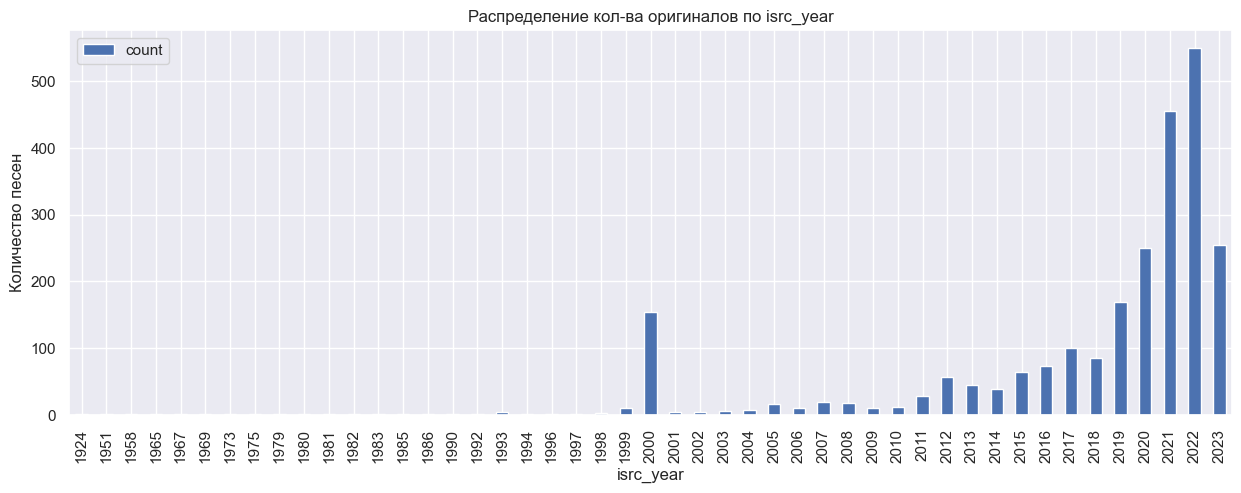

In [139]:
df_group_year_origin = (
        data[data["track_remake_type"] == "ORIGINAL"]
        .groupby(value, as_index=False)["track_id"]
        .count()
        .rename(columns={'track_id': 'count'})
)
print(f'#ТОП-10:{value}')
display(df_group_year_origin.sort_values(by="count", ascending=False).head(10))#ТОП-10

print()
df_group_year_origin.plot(value,'count',kind='bar', figsize=(15,5), grid = True)
plt.title(f'Распределение кол-ва оригиналов по {value}')
plt.xlabel(value)
plt.ylabel('Количество песен')
plt.show()

#ТОП-10:isrc_year


,isrc_year,count
62,2021,1697
63,2022,1065
61,2020,1017
60,2019,521
59,2018,394
58,2017,346
64,2023,319
57,2016,299
56,2015,257
41,2000,216


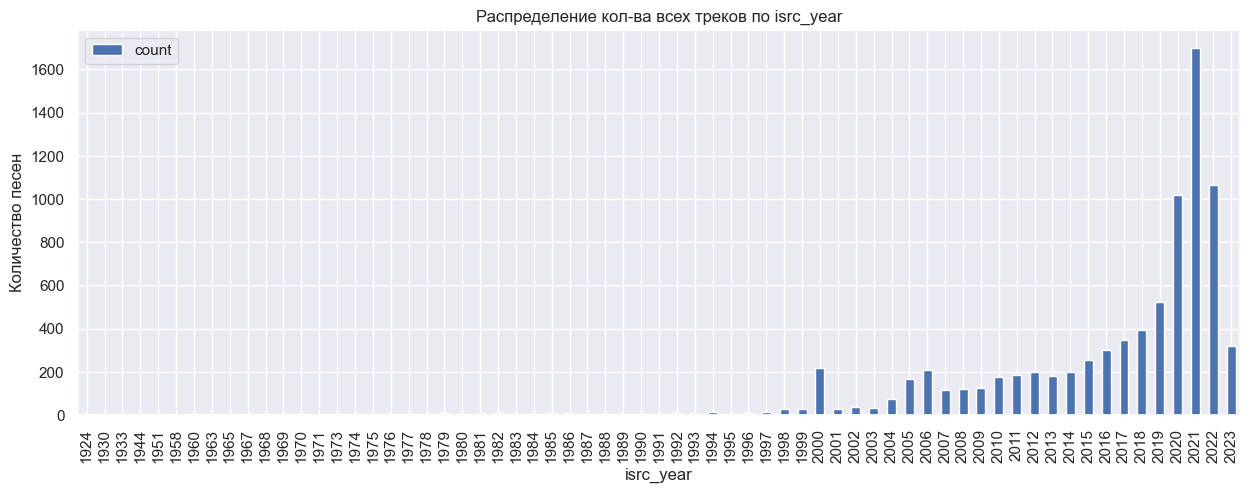

In [140]:
df_group_year = (
        data
        .groupby(value, as_index=False)["track_id"]
        .count()
        .rename(columns={'track_id': 'count'})
)
print(f'#ТОП-10:{value}')
display(df_group_year.sort_values(by="count", ascending=False).head(10))#ТОП-10

print()
df_group_year.plot(value,'count',kind='bar', figsize=(15,5), grid = True)
plt.title(f'Распределение кол-ва всех треков по {value}')
plt.xlabel(value)
plt.ylabel('Количество песен')
plt.show()

Можно наблюдать, что осовная масса данных сосредоточена за период 2000 - 2023 года. Пик кол-ва регистрации оригиналов приходится на 2022, а каверов за 2021

Год первой первого появлении ифномрации и год регистрации связаны?

#### Исследование длительности трека

**Проверим как менялась медианная длительность треков с годами**

Гипотеза,что раньше длительность треков была больше.

#ТОП-10:duration


,isrc_year,median
34,1993,273585.0
2,1933,262970.0
36,1995,262155.0
37,1996,255000.0
35,1994,246385.0
48,2007,245060.0
40,1999,242670.0
47,2006,242150.0
38,1997,241400.0
39,1998,239890.0


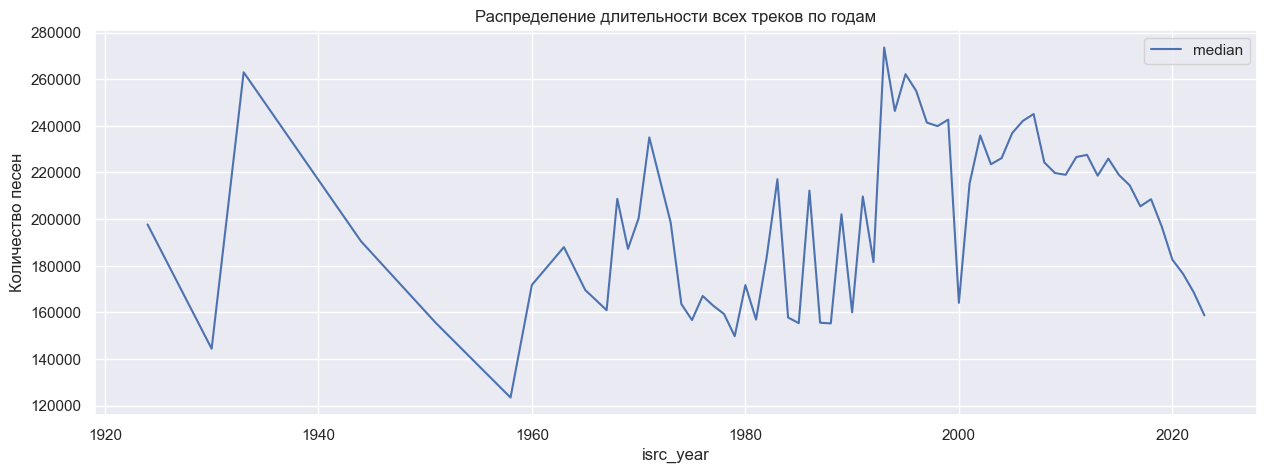

In [141]:
df_group_duration = (
        data
        .groupby('isrc_year', as_index=False)["duration"]
        .median()
        .rename(columns={'duration': 'median'})
)
print(f'#ТОП-10:duration')
display(df_group_duration.sort_values(by="median", ascending=False).head(10))#ТОП-10

print()
df_group_duration.plot('isrc_year','median', figsize=(15,5), grid = True)
plt.title(f'Распределение длительности всех треков по годам')
plt.xlabel(value)
plt.ylabel('Количество песен')
plt.show()

В 1993-1997 длительность треков наибольшая. Также есть скачоев 1940 годах. Гипотеза не подтвердилась, так как на графике не имеет закономерную тенденцию.

#### Исследование кол-во треков по популярности языка

#ТОП-10:language


,language,count
12,en,4043
13,es,727
39,pt,275
41,ru,272
25,it,56
16,fr,42
10,de,38
26,ja,34
50,th,32
54,vi,23


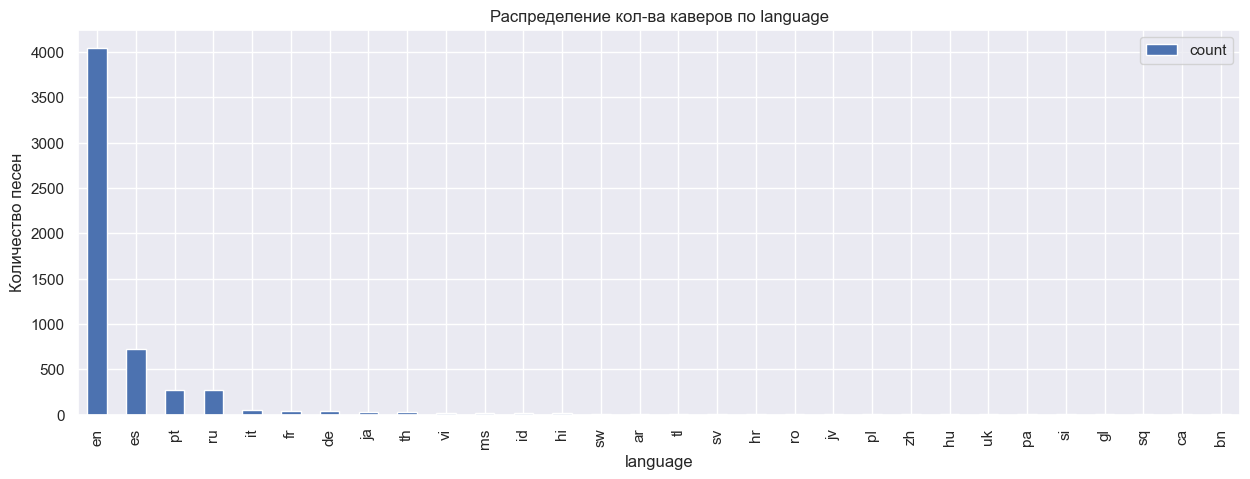

In [142]:
plot_info_cover('language',df_parsing)

#ТОП-10:language


,language,count
18,ru,1628
5,en,802
6,es,17
7,fr,12
21,uk,3
2,cy,2
20,sw,2
16,pt,2
13,mt,1
19,se,1


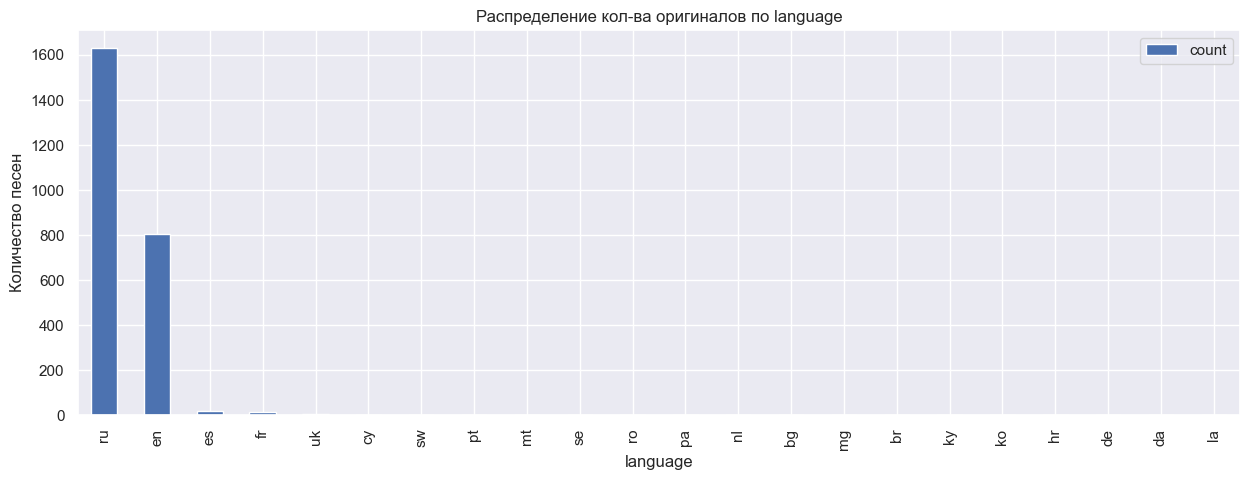

In [143]:
plot_info_original('language',df_parsing)

#ТОП-10:language


,language,count
14,en,4845
46,ru,1900
15,es,744
44,pt,277
27,it,56
18,fr,54
12,de,39
28,ja,34
56,th,32
38,ms,23


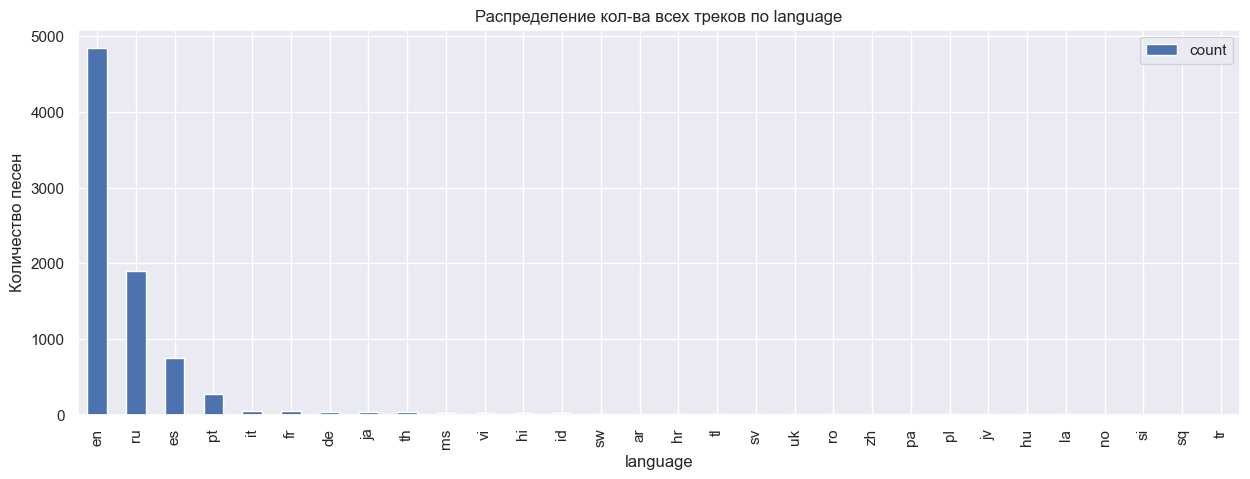

In [144]:
plot_info_all('language',df_parsing)

Выделяются основные 3 языка по всему датафрейму: английский, русский и испанский

Следующий этап подготовка текста к TF-IDF, но для начала удалим не нужные столбцы

In [145]:
df_parsing.columns

Index(['original_track_id', 'track_id', 'track_remake_type', 'lyricId', 'text',
       'dttm', 'title', 'language', 'isrc', 'genres', 'duration', 'artist',
       'release_date', 'dttm_year', 'isrc_country_iso', 'isrc_organization',
       'isrc_year', 'release_date_year'],
      dtype='object')

In [146]:
result = df_parsing.drop(['original_track_id',
                          'track_id',
                          'lyricId',
                          'dttm', 
                          'isrc',
                          'release_date', 
                          'dttm_year',
                          'release_date_year'], 
                         axis = 1
                        )

In [147]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  8226 non-null   object 
 1   text               8226 non-null   object 
 2   title              8226 non-null   object 
 3   language           8226 non-null   object 
 4   genres             8226 non-null   object 
 5   duration           8226 non-null   float64
 6   artist             8226 non-null   object 
 7   isrc_country_iso   8226 non-null   object 
 8   isrc_organization  8226 non-null   object 
 9   isrc_year          8226 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 642.8+ KB


#### **Выводы по третьему пункту:**

- Проведен анализ популярности треков по столбцоам. (выделен топ 10 по каждому )
- Замечено, что осовная масса данных сосредоточена за период 2000 - 2023 года. Пик кол-ва регистрации оригиналов приходится на 2022, а каверов за 2021
- В 1993-1997 длительность треков наибольшая. Длительность трека во врмемени разная. Нельзя сказать, что с годами она как-то меняется

## 4.Подготовка к TF-IDF 

Оценка важности слова определяется величиной TF-IDF. TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Для лемматизации мы должны разделить тексты на языковые группы. Начнем с английского.

In [148]:
result[result['text'].notna()].groupby('language')['language'].count().sort_values(ascending= False)

language
en    4845
ru    1900
es    744 
pt    277 
it    56  
fr    54  
de    39  
ja    34  
th    32  
ms    23  
vi    23  
hi    20  
id    20  
sw    14  
ar    10  
hr    9   
tl    8   
sv    8   
uk    8   
ro    8   
zh    6   
pa    6   
pl    6   
jv    6   
hu    5   
la    4   
no    3   
si    3   
sq    3   
tr    3   
ko    3   
bn    3   
ca    3   
gl    3   
br    3   
af    2   
ky    2   
cy    2   
he    2   
da    2   
ml    2   
sl    1   
bg    1   
be    1   
az    1   
sr    1   
as    1   
xh    1   
te    1   
an    1   
sk    1   
el    1   
fa    1   
fi    1   
ht    1   
nl    1   
mt    1   
is    1   
mn    1   
mg    1   
lv    1   
ka    1   
se    1   
Name: language, dtype: int64

Очень много единичных меток языков. Пока стоит Рассмотреть основные 3 группы: английский, русский и испанский. В сумме они дают:

In [149]:
sum_lan = len(result[result['language'] == 'en']) + \
        len(result[result['language'] == 'ru']) +\
        len(result[result['language'] == 'es'])
print('Количество текстов на основных языках в размеченных данных:', sum_lan)

print('Количество текстов на неосновных языках в размеченных данных:', len(result[(result['text'].notnull()) & (result['language'].notnull())]) - sum_lan) #сколько упускаем размеченных

Количество текстов на основных языках в размеченных данных: 7489
Количество текстов на неосновных языках в размеченных данных: 737


Создаем 3 датасета основных языков

In [150]:
df_en = result[result['language'] == 'en']

In [151]:
df_ru = result[result['language'] == 'ru']

In [152]:
df_es = result[result['language'] == 'es']

#### Английский

Функция очистки текста

In [153]:
def clear_text_en(text):

    def limit(text):
        #убираем слова длиной от 50 до 10000 символов
        #это ограничение на всякий
        lim = re.sub(r'\b\w{50,10000}\b', ' ', text) 
        lim1 = " ".join(lim.split()) #применяем фильтр
        return lim1

    clear = re.sub(r'[^a-zA-Z ]', ' ', limit(text)) #фильтруем латиницу, символы
    clear1 = " ".join(clear.split()) #применяем фильтр
    return clear1

Лемматизатор

In [154]:
stopwords_en = stopwords.words("english")
def lemmatize_text_en(text):
    tokens = []
    for token in text.split():
        if token and token not in stopwords_en:
            token = token.strip()
            token = lemmatize_sentence(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [155]:
tqdm.pandas()

In [156]:
df_en['text'] = df_en['text'].progress_apply(clear_text_en) #выполняем очистку
df_en['text'] = df_en['text'].progress_apply(lemmatize_text_en) #лемматизируем текст
df_en.head()

100%|███████████████████████████████████████| 4845/4845 [03:02<00:00, 26.57it/s]


,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
0,ORIGINAL,"[leave, good, job, city, workin, man, ev, ry, night, day, and, i, never, lose, one, minute, sleepin, worryin, bout, way, thing, might, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, clean, lot, plate, memphis, pump, lot, pane, new, orleans, but, i, never, saw, good, side, city, til, i, hitch, ride, riverboat, queen, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, rollin, rollin, rollin, river, if, come, river, bet, gon, find, people, live, you, worry, cause, money, people, river, happy, give, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, ...]",Proud Mary,en,ROCK ALLROCK,187220.0,Creedence Clearwater Revival,US,FI8,1969
1,ORIGINAL,"[some, folk, born, make, wave, flag, ooh, red, white, blue, and, band, play, hail, chief, ooh, point, cannon, lord, it, i, senator, son, son, it, i, fortunate, one, some, folk, born, silver, spoon, hand, lord, help, lord, but, taxman, come, door, lord, house, lookin, like, rummage, sale, yeah, it, i, millionaire, son, it, i, fortunate, one, yeah, yeah, folk, inherit, star, spangle, eye, ooh, send, war, lord, and, ask, em, how, much, give, hoo, answer, more, it, i, military, son, son, lord, it, i, fortunate, one, one, it, i, fortunate, one, it, i, fortunate, son, it]",Fortunate Son,en,ROCK ALLROCK,137780.0,Creedence Clearwater Revival,US,FI8,1969
3,ORIGINAL,"[yeah, yeah, remember, time, baby, yeah, i, get, money, i, get, car, take, date, i, even, buy, flower, but, together, perfect, soulmates, talk, girl, oh, baby, alright, get, flaunt, if, go, touch, still, touch, love, free, we, work, without, perk, work, til, get, right, baby, strip, get, tip, cause, i, like, way, i, strip, i, well, equip, can, handle, way, i, i, need, g, car, key, boy, i, like, way, let, see, ya, strip, get, tip, cause, i, like, i, like, i, like, i, get, visa, i, get, red, american, express, we, go, nowhere, exotic, it, matter, cause, i, one, ...]",The Way I Are,en,FOREIGNRAP RAP,179660.0,"Timbaland, Keri Hilson, D.O.E.",US,UM7,2007
4,COVER,"[can, buy, love, can, buy, love, can, buy, love, i, buy, diamond, ring, friend, if, make, feel, alright, i, get, anything, friend, if, make, feel, alright, for, i, care, much, money, for, money, buy, love, i, give, i, get, give, if, say, love, i, may, awful, lot, but, i, get, i, give, for, i, care, much, money, for, money, buy, love, can, buy, love, love, can, buy, love, say, need, diamond, ring, and, i, satisfied, tell, want, kind, thing, that, money, buy, i, care, much, money, for, money, buy, love, don, want, money, who, want, money, i, care, much, money, ...]",Can't Buy Me Love,en,JAZZ VOCALJAZZ,158950.0,Ella Fitzgerald,US,GR1,2001
5,COVER,"[wednesday, morning, five, clock, a, day, begin, silently, closing, bedroom, door, leave, note, hop, would, say, she, go, downstairs, kitchen, clutch, handkerchief, quietly, turn, back, door, key, step, outside, free, she, give, life, is, leave, sacrifice, life, home, give, everything, money, could, buy, she, leave, home, living, alone, so, many, year, bye, bye, father, snore, wife, get, dress, gown, pick, letter, lie, stand, alone, top, stair, she, break, cry, husband, daddy, baby, go, why, would, treat, u, thoughtlessly, how, could, she, we, never, thought, is, leave, never, thought, home, struggle, hard, life, get, she, leave, home, living, alone, so, many, ...]",She's Leaving Home,en,JAZZ,356070.0,McCoy Tyner,US,GR1,1999


#### Русский

In [157]:
def clear_text_ru(text):

    def limit(text):
        #убираем слова длиной от 50 до 10000 символов
        #это ограничение на всякий
        lim = re.sub(r'\b\w{50,10000}\b', ' ', text) 
        lim1 = " ".join(lim.split()) #применяем фильтр
        return lim1

    clear = re.sub(r'[^А-Яа-я]', ' ', limit(text)) #фильтруем кириллицу, символы
    clear1 = " ".join(clear.split()) #применяем фильтр
    return clear1

In [158]:
stopwords_ru = stopwords.words("russian")
morph_ru = MorphAnalyzer()

def lemmatize_text_ru(text):
    tokens = []
    for token in text.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph_ru.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [159]:
df_ru['text'] = df_ru['text'].progress_apply(clear_text_ru) #выполняем очистку
df_ru['text'] = df_ru['text'].progress_apply(lemmatize_text_ru)
df_ru.head()

100%|███████████████████████████████████████| 1900/1900 [00:36<00:00, 51.90it/s]


,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
317,ORIGINAL,"[я, закрой, себя, сказать, я, стоить, я, подбросить, удача, докурить, пойти, далёкий, не, дожд, тесь, заплатить, любой, получить, сдача, я, фильм, главный, акт, р, сценарист, н, м, режисса, р, враг, бояться, друг, отрекаться, нелюбимый, простить, любимый, любить, враг, бояться, друг, отрекаться, нелюбимый, простить, любимый, любить, на, минута, замечтаться, летать, пытаться, упад, подниматься, вс, порядок, оклематься, не, дожд, тесь, заплатить, любой, получить, сдача, я, фильм, главный, акт, р, сценарист, н, м, режисса, р, враг, бояться, друг, отрекаться, нелюбимый, простить, любимый, любить, враг, бояться, друг, отрекаться, нелюбимый, простить, любимый, любить, враг, бояться, друг, отрекаться, нелюбимый, простить, любимый, любить, враг, бояться, друг, отрекаться, ...]",Режиссер,ru,POP RUSPOP,219350.0,Gradusy,QM,PU5,2012
318,COVER,"[кто, знать, распускать, слух, зря, что, жить, печаль, забота, что, свет, удачливый, и, вс, м, везти, так, также, также, я, земля, ходить, ходить, и, судьба, счастие, просить, счастие, просить, вы, верить, жить, рай, и, обходить, сторона, беда, точно, вечер, уставать, и, грустить, реветь, также, также, я, земля, ходить, ходить, и, судьба, счастие, просить, счастие, просить, также, также, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие, счастие]",Так же как все,ru,POP RUSPOP,225060.0,A'Studio,RU,A7C,2018
319,ORIGINAL,"[пешеход, достать, и, обычно, мало, я, сидеть, понемногу, вникать, ну, больший, окно, трамвай, кто, балкон, повиснуть, кто, быстро, вверх, вниз, я, пока, рисовать, мост, а, а, кто, кто, балкон, повиснуть, кто, быстро, вверх, вниз, я, организовать, мост, а, а, кто, у, один, закипать, мотор, закрывать, глаз, прибор, я, пытаться, понимать, для, человек, китай, кто, балкон, повиснуть, кто, быстро, вверх, вниз, я, пока, рисовать, мост, а, а, кто, кто, балкон, повиснуть, кто, быстро, вверх, вниз, я, организовать, мост, а, а, кто, кто, балкон, повиснуть, кто, быстро, вверх, вниз, я, пока, рисовать, мост, а, а, кто, кто, балкон, повиснуть, кто, быстро, вверх, ...]",Кто ты?,ru,POP RUSPOP,205190.0,Gradusy,QM,PU5,2012
428,ORIGINAL,"[сквозь, туман, дорога, что, манить, я, туда, отпустить, сам, виноватый, сам, ругать, знать, суметь, я, понять, и, винить, но, причина, другой, семья, только, знать, пролетать, день, мимо, что, я, я, замечать, улыбка, ты, это, конец, фильм, так, в, жизнь, стать, уныло, без, знать, пролетать, день, мимо, что, я, я, замечать, улыбка, я, твой, это, конец, фильм, без, только, хотеться, в, свет, плачущий, фара, по, дорога, идти, туда, никуда, я, ночь, спасть, я, везде, искать, знать, суметь, я, понять, и, винить, но, причина, другой, семья, только, знать, пролетать, день, мимо, что, я, я, замечать, улыбка, я, твой, это, конец, фильм, так, ...]",Другая причина,ru,POP RUSPOP,248920.0,Nepara,QM,PU5,2015
559,ORIGINAL,"[всё, просто, получаться, мир, маятник, качаться, а, свет, переключаться, звук, на, расстояние, выстрел, рассчитывать, бессмысленно, что, истина, выскользнуть, рука, и, порваться, бесконечный, круг, вне, зона, доступ, неопознанный, вне, зона, доступ, дышать, воздух, вне, зона, доступ, вполне, осознанно, вне, зона, доступ, вне, зона, доступ, вне, зона, доступ, совсем, необязательно, ждать, помощь, спасатель, два, шаг, касательная, наверх, два, жизнь, сближение, и, изнеможение, скрыть, местоположение, незримый, полоса, помеха, вне, зона, доступ, неопознанный, вне, зона, доступ, дышать, воздух, вне, зона, доступ, вполне, осознанно, вне, зона, доступ, вне, зона, доступ, вне, зона, доступ, вне, зона, доступ, неопознанный, вне, зона, доступ, дышать, воздух, вне, зона, доступ, ...]",Вне зоны доступа,ru,RUSROCK ALLROCK,213550.0,Gorod 312,RU,A77,2013


#### Испанский

In [160]:
def clear_text_es(text):

    def limit(text):
        #убираем слова длиной от 50 до 10000 символов
        #это ограничение на всякий
        lim = re.sub(r'\b\w{50,10000}\b', ' ', text) 
        lim1 = " ".join(lim.split()) #применяем фильтр
        return lim1
    text = text.lower()
    clear = re.sub(r'[^a-záéíóúñ]', ' ', limit(text)) #фильтруем кириллицу, символы
    clear1 = " ".join(clear.split()) #применяем фильтр
    return clear1

In [161]:
stopwords_es = stopwords.words("spanish")
nlp = spacy.load('es_core_news_md')

def lemmatize_text_es(text):
    document = nlp(text)
# Create a lemmatized version of the original text file
    tokens = []
    for token in document:
        if token and token not in stopwords_es:
            # Get the lemma for each token
            token = token.lemma_
            # Insert white space between each token
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [162]:
df_es['text'] = df_es['text'].progress_apply(clear_text_es) #выполняем очистку
df_es['text'] = df_es['text'].progress_apply(lemmatize_text_es)
df_es.head()

100%|█████████████████████████████████████████| 744/744 [00:20<00:00, 36.95it/s]


,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
2,ORIGINAL,"[uno, por, pobre, y, feo, hombre, pero, antojar, o, ay, ome, tener, el, camisa, negro, hoy, mi, amor, estar, de, luto, hoy, tener, en, el, alma, uno, pena, y, ser, por, culpa, de, tu, embrujo, hoy, saber, que, tú, ya, no, yo, querer, y, ese, ser, él, que, más, yo, herir, que, tener, el, camisa, negro, y, uno, pena, que, yo, doler, mal, parecer, que, solo, yo, quedar, y, ser, puro, todita, tu, mentira, qué, malditar, mala, suerte, él, mía, que, aquel, día, tú, encontrar, por, beber, del, veneno, malevo, de, tu, amor, yo, quedar, moribundo, y, lleno, de, dolor, ...]",La Camisa Negra,es,POP FOLK LATINFOLK,216840.0,Juanes,US,UL1,2004
54,COVER,"[bésame, bésame, mucho, como, si, ser, este, noche, el, último, vez, bésamar, bésamar, mucho, que, tener, miedo, a, pererte, perderte, después, bésamar, bésamar, mucho, como, si, ser, este, noche, el, último, vez, bésamar, bésamar, mucho, que, tener, miedo, a, perderte, perderte, después, querer, tenertar, mucho, cerca, mirar yo, en, tu, ojo, verter, junto, a, yo, pensar, que, talvez, mañana, yo, ya, estar, lejos, mucho, lejos, de, tú, bésame, bésamar, mucho, como, si, ser, este, noche, el, último, vez, bésamar, bésamar, mucho, que, tener, miedo, a, perderte, perderte, después, bésamar, bésamar, mucho, que, tener, miedo, a, perderte, perderte, después, que, tener, miedo, ...]",Bésame Mucho,es,CLASSICALMUSIC VOCAL,244330.0,"Consuelo Velázquez, Andrea Bocelli",IT,Z04,2005
126,ORIGINAL,"[qué, hora, ser, mi, corazón, qué, hora, ser, mi, corazón, qué, hora, ser, mi, corazón, qué, hora, ser, mi, corazón, a, el, bin, a, el, ban, a, el, bin, bon, bam, a, el, bin, a, el, ban, a, el, bin, bon, bam, obladí, obladá, obladí, dar, dar, a, el, bin, a, el, ban, a, el, bin, bon, bam, tú, él, decir, bien, clarito, permanecer, a, el, escucha, permanecer, a, el, escucha, tú, él, decir, bien, clarito, permanecer, a, el, escucha, permanecer, a, el, escucha, tú, él, decir, bien, clarito, permanecer, a, el, escucha, permanecer, a, el, escucha, qué, hora, ser, ...]",Me Gustas Tú,es,SKA,239980.0,Manu Chao,FR,84R,2000
210,ORIGINAL,"[cómo, decir, que, yo, partir, en, mil, el, esquinita, de, mi, hueso, que, haber, caer, el, esquema, de, mi, vida, ahora, que, todo, ser, perfecto, y, algo, más, que, ese, yo, a, sorbiste, el, seso, y, yo, descender, el, peso, de, este, cuerpecito, mío, que, él, haber, convertir, en, río, de, este, cuerpecito, mío, que, él, haber, convertir, en, río, yo, costar, abrir, el, ojo, y, él, hacer, poco, a, poco, no, ser, que, aún, tú, encontrar, cerca, yo, guardar, tu, recuerdo, como, el, mejor, secreto, qué, dulce, ser, tenertar, dentro, haber, uno, trozo, de, luz, en, este, oscuridad, para, ...]",Siempre Me Quedará,es,POP,229660.0,Bebe,ES,503,2004
356,ORIGINAL,"[ay, payita, mío, guárdatir, el, poesía, guárdatir, el, alegría, pa, tú, damar, dámelo, oh, ah, no, pedir, que, todo, el, día, ser, de, sol, no, pedir, que, todo, el, viernes, ser, de, fiesta, tampoco, tú, pedir, que, vuelvas, rogar, perdón, si, llorar, con, el, ojo, seco, y, hablar, de, él, ay, amor, yo, doler, tanto, yo, doler, tanto, que, tú, fuerar, sin, decir, a, donde, ay, amor, ser, uno, tortura, perdertar, yo, él, que, no, haber, ser, uno, santo, pero, él, poder, arreglar, amor, no, solo, de, pan, vivir, el, hombre, y, no, de, excusa, vivo, yo, solo, de, error, ...]",La Tortura,es,POP,212890.0,"Shakira, Alejandro Sanz",US,SM1,2005


#### Мультиязычный - для неосновных языков

In [163]:
df_mling = result[
    (result["language"] != "en")
    & (result["language"] != "ru")
    & (result["language"] != "es")
].reset_index(drop=True)
df_mling.head(2)


,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
0,COVER,Se se vaan on sillä lailla\nEttä tässäki maassa\nSitä on paljon mälsää\nEi sitä tartte edes paljon kavereilta kysellä\nKun vaan viittii vähänkin tsiikata ympärilleen\nKaiken maailman törpötkin ne luulee olevansa vaikka mitä\nMut ei ne oo ku hemmetinmoisia sössöjä vaan\nOn sitä ollu ennenski nuijasotia tässä maassa\nMut olispa täs nuijalla töitä\nJa hyvä olis saada muijallekkin töitä\nIttestä ei oo niin väliä juu\n\nTässä maassa on niin huonot liksat\nEttä nälkä on aina vieraanamme\nMut eipä oo onneks jano päässy vielä yllättämään\nOn sitä tässä yks ja toinenki sentäs jotakin nähny\nVoi olla että vielä käydään ulkomaillakin\nEttei sitä nyt tartte ihan silmille tulla hyppimään,Rotestilaulu,fi,METAL DOOMMETAL,270100.0,Reverend Bizarre,FI,UM7,2008
1,ORIGINAL,"Я сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\nЯ сошла с ума\n\nМеня полностью нет, абсолютно всерьез\nСитуация help, ситуация SOS\nЯ себя не пойму, ты откуда взялась\nПочему, почему, на тебя повелась?\n\nВыключается свет, я куда-то лечу\nБез тебя меня нет, ничего не хочу\nЭто медленный яд, это сводит с ума\nА они говорят - виновата сама\nА они говорят - виновата сама\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она\nМне нужна она, мне нужна она\nМне нужна она, мне нужна она\nМне нужна она, мне нужна она\nМне нужна она\n\nБез тебя я не я, без тебя меня нет\nА они говорят, говорят это бред\nЭто солнечный яд, золотые лучи\nА они говорят, надо срочно лечить\n\nЯ хотела забыть, до упора и вниз\nЯ считала столбы и растерянных птиц\nБез тебя меня нет, отпусти, отпусти\nДо угла по стене, мама, папа, прости\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она (Мне нужна она)\nМне нужна она, мне нужна она\nМне нужна она, мне нужна она\nМне нужна она, мне нужна она\nОна\nМне нужна она, мне нужна она\n\nРаз, два, после пяти\nМама, папа, прости\nЯ сошла с ума\n\nРаз, два после пяти\nМама, папа, прости\nЯ сошла с ума\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она, мне нужна она\nМне нужна она\n\nЯ сошла с ума, я сошла с ума\nМне нужна она\nЯ сошла с ума, я сошла с ума\nЯ сошла с ума, я сошла с ума\nЯ сошла с ума, я сошла с ума",Я сошла с ума,bg,POP RUSPOP,213780.0,t.A.T.u.,RU,A11,2001


In [164]:
def clear_text_mling(text):

    def limit(text):
        #убираем слова длиной от 50 до 10000 символов
        #это ограничение на всякий
        lim = re.sub(r'\b\w{50,10000}\b', ' ', text) 
        lim1 = " ".join(lim.split()) #применяем фильтр
        return lim1
    text = text.lower()
    clear = re.sub('\W+',' ', limit(text)) #фильтруем кириллицу, символы
    clear1 = " ".join(clear.split()) #применяем фильтр
    return clear1

In [165]:
df_mling['text'] = df_mling['text'].progress_apply(clear_text_mling) #выполняем очистку, т.к. датасет - другой

100%|███████████████████████████████████████| 737/737 [00:00<00:00, 7812.34it/s]


In [166]:
df_mling.head(2)

,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
0,COVER,se se vaan on sillä lailla että tässäki maassa sitä on paljon mälsää ei sitä tartte edes paljon kavereilta kysellä kun vaan viittii vähänkin tsiikata ympärilleen kaiken maailman törpötkin ne luulee olevansa vaikka mitä mut ei ne oo ku hemmetinmoisia sössöjä vaan on sitä ollu ennenski nuijasotia tässä maassa mut olispa täs nuijalla töitä ja hyvä olis saada muijallekkin töitä ittestä ei oo niin väliä juu tässä maassa on niin huonot liksat että nälkä on aina vieraanamme mut eipä oo onneks jano päässy vielä yllättämään on sitä tässä yks ja toinenki sentäs jotakin nähny voi olla että vielä käydään ulkomaillakin ettei sitä nyt tartte ihan silmille tulla hyppimään,Rotestilaulu,fi,METAL DOOMMETAL,270100.0,Reverend Bizarre,FI,UM7,2008
1,ORIGINAL,я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума меня полностью нет абсолютно всерьез ситуация help ситуация sos я себя не пойму ты откуда взялась почему почему на тебя повелась выключается свет я куда то лечу без тебя меня нет ничего не хочу это медленный яд это сводит с ума а они говорят виновата сама а они говорят виновата сама я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она без тебя я не я без тебя меня нет а они говорят говорят это бред это солнечный яд золотые лучи а они говорят надо срочно лечить я хотела забыть до упора и вниз я считала столбы и растерянных птиц без тебя меня нет отпусти отпусти до угла по стене мама папа прости я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она мне нужна она она мне нужна она мне нужна она раз два после пяти мама папа прости я сошла с ума раз два после пяти мама папа прости я сошла с ума я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она мне нужна она мне нужна она я сошла с ума я сошла с ума мне нужна она я сошла с ума я сошла с ума я сошла с ума я сошла с ума я сошла с ума я сошла с ума,Я сошла с ума,bg,POP RUSPOP,213780.0,t.A.T.u.,RU,A11,2001


In [167]:
# list of supported languages:

sup_lan = ['ast', 'bg', 'ca', 'cs', 'cy', 'da', 'de', 'el', 'en', 'enm', 'es', 
           'et', 'fa', 'fi', 'fr', 'ga', 'gd', 'gl', 'gv', 'hbs', 'hi', 'hu', 
           'id', 'is', 'it', 'ka', 'la', 'lb', 'lt', 'lv', 'mk', 'ms', 'nb', 
           'nl', 'nn', 'pl', 'pt', 'ro', 'ru', 'se', 'sk', 'sl', 'sq', 'sv', 
           'sw', 'tl', 'tr', 'uk']

In [168]:
def lemmatize_text_mling(text, l):
    tokens = []
    for token in text:
        token = simplemma.lemmatize(token, lang=l)
        tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [169]:
for i in tqdm(range(len(df_mling))):
    if df_mling['language'][i] in sup_lan:
        df_mling['text'][i] = lemmatize_text_mling(df_mling['text'][i].split(), df_mling['language'][i])

100%|█████████████████████████████████████████| 737/737 [02:37<00:00,  4.69it/s]


In [170]:
frames = [df_en, df_ru, df_es, df_mling]

result_lem = pd.concat(frames).reset_index(drop= True)

Появилось два пропуска по тексту - значит они не прошли фильтр очистки текста. Удалим эти строки.

In [171]:
result_lem = result_lem[result_lem['text'].notna()].reset_index(drop= True)

Заменяем значения оригинала и кавера на категории: 1 и 0.

In [172]:
di = {'ORIGINAL': 1, 'COVER': 0}

In [173]:
result_lem['track_remake_type'] = result_lem['track_remake_type'].replace(di)

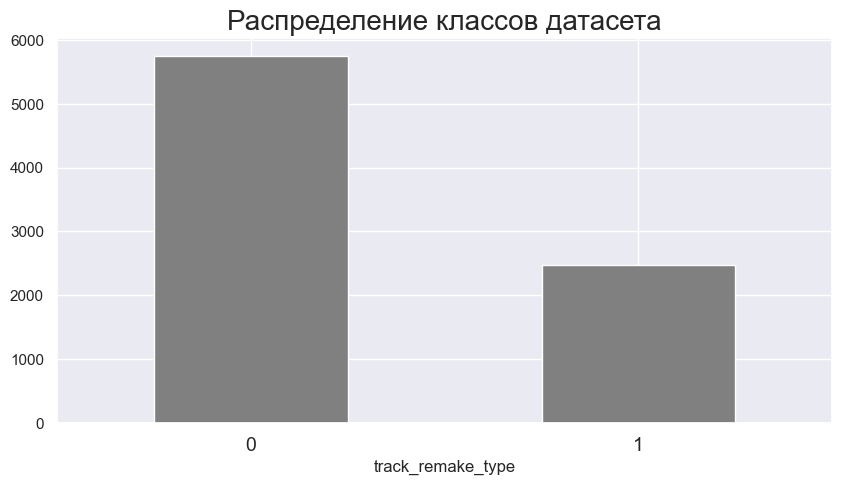

In [174]:
bar1 = result_lem.groupby('track_remake_type')['track_remake_type'].count()
bar1.plot(kind='bar', figsize=(10, 5), color='grey') #столб.диаграмма по сводной таблице с указанным размером
bw = 0.3 #толщина столбика
plt.title('Распределение классов датасета', fontsize=20) #имя графика
plt.xticks(fontsize=14, rotation=0); #показать подпись, убрать поворот

In [175]:
result_lem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  8226 non-null   int64  
 1   text               8226 non-null   object 
 2   title              8226 non-null   object 
 3   language           8226 non-null   object 
 4   genres             8226 non-null   object 
 5   duration           8226 non-null   float64
 6   artist             8226 non-null   object 
 7   isrc_country_iso   8226 non-null   object 
 8   isrc_organization  8226 non-null   object 
 9   isrc_year          8226 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 642.8+ KB


In [176]:
result_lem.head(3)

,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
0,1,"[leave, good, job, city, workin, man, ev, ry, night, day, and, i, never, lose, one, minute, sleepin, worryin, bout, way, thing, might, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, clean, lot, plate, memphis, pump, lot, pane, new, orleans, but, i, never, saw, good, side, city, til, i, hitch, ride, riverboat, queen, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, rollin, rollin, rollin, river, if, come, river, bet, gon, find, people, live, you, worry, cause, money, people, river, happy, give, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, ...]",Proud Mary,en,ROCK ALLROCK,187220.0,Creedence Clearwater Revival,US,FI8,1969
1,1,"[some, folk, born, make, wave, flag, ooh, red, white, blue, and, band, play, hail, chief, ooh, point, cannon, lord, it, i, senator, son, son, it, i, fortunate, one, some, folk, born, silver, spoon, hand, lord, help, lord, but, taxman, come, door, lord, house, lookin, like, rummage, sale, yeah, it, i, millionaire, son, it, i, fortunate, one, yeah, yeah, folk, inherit, star, spangle, eye, ooh, send, war, lord, and, ask, em, how, much, give, hoo, answer, more, it, i, military, son, son, lord, it, i, fortunate, one, one, it, i, fortunate, one, it, i, fortunate, son, it]",Fortunate Son,en,ROCK ALLROCK,137780.0,Creedence Clearwater Revival,US,FI8,1969
2,1,"[yeah, yeah, remember, time, baby, yeah, i, get, money, i, get, car, take, date, i, even, buy, flower, but, together, perfect, soulmates, talk, girl, oh, baby, alright, get, flaunt, if, go, touch, still, touch, love, free, we, work, without, perk, work, til, get, right, baby, strip, get, tip, cause, i, like, way, i, strip, i, well, equip, can, handle, way, i, i, need, g, car, key, boy, i, like, way, let, see, ya, strip, get, tip, cause, i, like, i, like, i, like, i, get, visa, i, get, red, american, express, we, go, nowhere, exotic, it, matter, cause, i, one, ...]",The Way I Are,en,FOREIGNRAP RAP,179660.0,"Timbaland, Keri Hilson, D.O.E.",US,UM7,2007


#### **Выводы по четвертому пункту:**

- выполнена очистка текста в зависимости от языка. Замечено, что самый популярные язык: Английский, Русский, Испанский
- выполнена лемматизация текстов

## 5.Выделение признаков

### Выделение целеовго признака и признаков

In [177]:
def try_join(l):
    try:
        return ', '.join(map(str, l))
    except TypeError:
        return np.nan

result_lem['text'] = [try_join(l) for l in result_lem['text']]

In [178]:
result_lem.head()

,track_remake_type,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
0,1,"leave, good, job, city, workin, man, ev, ry, night, day, and, i, never, lose, one, minute, sleepin, worryin, bout, way, thing, might, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, clean, lot, plate, memphis, pump, lot, pane, new, orleans, but, i, never, saw, good, side, city, til, i, hitch, ride, riverboat, queen, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, rollin, rollin, rollin, river, if, come, river, bet, gon, find, people, live, you, worry, cause, money, people, river, happy, give, big, wheel, keep, turnin, proud, mary, keep, burnin, rollin, rollin, rollin, river, rollin, rollin, rollin, river, rollin, rollin, rollin, river, rollin, rollin, rollin",Proud Mary,en,ROCK ALLROCK,187220.0,Creedence Clearwater Revival,US,FI8,1969
1,1,"some, folk, born, make, wave, flag, ooh, red, white, blue, and, band, play, hail, chief, ooh, point, cannon, lord, it, i, senator, son, son, it, i, fortunate, one, some, folk, born, silver, spoon, hand, lord, help, lord, but, taxman, come, door, lord, house, lookin, like, rummage, sale, yeah, it, i, millionaire, son, it, i, fortunate, one, yeah, yeah, folk, inherit, star, spangle, eye, ooh, send, war, lord, and, ask, em, how, much, give, hoo, answer, more, it, i, military, son, son, lord, it, i, fortunate, one, one, it, i, fortunate, one, it, i, fortunate, son, it",Fortunate Son,en,ROCK ALLROCK,137780.0,Creedence Clearwater Revival,US,FI8,1969
2,1,"yeah, yeah, remember, time, baby, yeah, i, get, money, i, get, car, take, date, i, even, buy, flower, but, together, perfect, soulmates, talk, girl, oh, baby, alright, get, flaunt, if, go, touch, still, touch, love, free, we, work, without, perk, work, til, get, right, baby, strip, get, tip, cause, i, like, way, i, strip, i, well, equip, can, handle, way, i, i, need, g, car, key, boy, i, like, way, let, see, ya, strip, get, tip, cause, i, like, i, like, i, like, i, get, visa, i, get, red, american, express, we, go, nowhere, exotic, it, matter, cause, i, one, love, best, talk, girl, oh, baby, alright, get, flaunt, if, go, touch, still, touch, love, free, we, work, without, perk, work, til, get, right, baby, strip, get, tip, cause, i, like, way, i, strip, i, well, equip, can, handle, way, i, i, need, g, car, key, boy, i, like, way, let, see, ya, strip, get, tip, cause, i, like, way, baby, girl, i, get, huge, ol, house, i, rent, room, house, listen, baby, girl, i, get, motorboat, i, float, ya, boat, so, listen, baby, girl, get, dose, d, o, e, gon, want, mo, so, listen, baby, girl, i, make, i, want, want, yeah, yeah, money, loof, like, feel, and, realy, quite, louis, allason, your, body, pamela, anderson, it, struggle, get, caravan, but, listen, baby, girl, before, i, let, lose, pound, i, buy, big, car, so, listen, baby, girl, i, love, way, way, oh, baby, alright, get, floss, if, go, touch, still, touch, love, free, we, work, without, perk, thug, til, get, right, baby, strip, get, tip, cause, i, like, way, i, strip, i, want, quick, can, handle, way, i, i, need, cheese, car, key, boy, i, like, way, let, see, ya, strip, get, tip, cause, i, like, way, baby, strip, get, tip, cause, i, like, way, i, strip, i, want, quick, can, handle, way, i, i, need, cheese, car, key, boy, i, like, way, let, see, ya, strip, get, tip, cause, i, like, i, like, i, like",The Way I Are,en,FOREIGNRAP RAP,179660.0,"Timbaland, Keri Hilson, D.O.E.",US,UM7,2007
3,0,"can, buy, love, can, buy, love, can, buy, love, i, buy, diamond, ring, friend, if, make, feel, alright, i, get, anything, friend, if, make, feel, alright, for, i, care, much, money, for, money, buy, love, i, give, i, get, give, if, say, love, i, may, awful, lot, but, i, get, i, give, for, i, care, much, money, for, money, buy, love, can, buy, love, love, can, buy, love, say, need, diamond, ring, and, i, satisfied, tell, want, kind, thing, 

In [179]:
(
    features_train_lem,
    features_test_lem,
    target_train_lem,
    target_test_lem,
) = train_test_split(  # создаем 4 датасета, два признаков (тест+валидация) и два целевых,
    result_lem.drop(
        columns="track_remake_type"
    ),  # для датасетов признаков удаляем целевой
    result_lem["track_remake_type"],  # для целевого оставляем только целевой
    test_size=0.2,  # с соотношением
    random_state=RANDOM_STATE,  # с заданной опорой для рандома
    stratify=result_lem["track_remake_type"],
)  # с заданной стратификацией по целевому признаку


### Обучение для TF-IDF

In [180]:
stop_words = set(stopwords.words(['russian', 'english', 'spanish', 'portuguese'])) 

In [181]:
corpus_train = features_train_lem["text"].values  # создаем корпус текстов
count_tf_idf_train = TfidfVectorizer(
    stop_words=list(stop_words)
)  # создаем счетчик величин TF-IDF, с учетом стоп слов
tf_idf_train = count_tf_idf_train.fit_transform(
    corpus_train
)  # передаем счётчику корпус текстов (fit запускается только на обучающей выборке)
tf_idf_train.shape


(6580, 40088)

In [182]:
corpus_test = features_test_lem['text'].values

In [183]:
count_tf_idf_train

TfidfVectorizer(stop_words=['am', 'estaríamos', 'он', 'tengas', 'havemos',
                            'those', 'isso', 'tanto', 'ведь', 'between', 'tuve',
                            'aquilo', 'some', 'fomos', 'about', 'couldn',
                            'tive', 'otras', 'in', 'tivéssemos', 'they', 'из',
                            'no', 'как', 'hayas', 'eles', 'tenemos', 'hubiese',
                            'her', 'yo', ...])

In [184]:
# print(tf_idf_train)

In [185]:
type(tf_idf_train)

scipy.sparse._csr.csr_matrix

#### **Выводы по пятому пункту:**

- Целевой признак: track_remake_type
- Признаки: text,	title,	language,	genres,	duration,	artist,	isrc_country_iso,	isrc_organization	isrc_year
- выполнено обучение для TF-IDF

## 6.Обучение моделей

### Логистическая регрессия

Посмотрим как ведут себя данные на логистической регрессии на тексте

In [186]:
%%time

log_reg_lem = LogisticRegression(
    solver="liblinear", class_weight="balanced", random_state=RANDOM_STATE
)  # максимальное количество итераций 1000,
pipeline_log_reg_lem = make_pipeline(count_tf_idf_train, log_reg_lem)
parameters = {
    "logisticregression__max_iter": range(100, 1000, 100),
    "logisticregression__C": np.arange(0.1, 10.0, 0.1),
    "logisticregression__penalty": ["l1", "l2"],
}  # перебор гиперпараметров

rand_log_reg_lem = RandomizedSearchCV(
    pipeline_log_reg_lem,
    n_iter=20,
    param_distributions=parameters,
    scoring="f1",
    n_jobs=-2,
    cv=3,
)
rand_log_reg_lem.fit(corpus_train, target_train_lem.values)

best_log_reg_lem = rand_log_reg_lem.best_score_

print(
    "Лучшие параметры для модели логистической регрессии с "
    "использованием кросс-валидации:",
    rand_log_reg_lem.best_params_,
)
print(
    "Наибольшее значение метрики F1 для модели логистической регрессии "
    "при лучших гиперпараметрах с использованием кросс-валидации:",
    best_log_reg_lem,
)


Лучшие параметры для модели логистической регрессии с использованием кросс-валидации: {'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 700, 'logisticregression__C': 0.6}
Наибольшее значение метрики F1 для модели логистической регрессии при лучших гиперпараметрах с использованием кросс-валидации: 0.7422829517396816
CPU times: user 1.5 s, sys: 799 ms, total: 2.3 s
Wall time: 8.15 s


In [187]:
%%time

log_reg_lem_1 = rand_log_reg_lem.best_estimator_
log_reg_lem_1.fit(corpus_train, target_train_lem.values)

predictions_log_reg_lem_1 = log_reg_lem_1.predict(corpus_test)

log_reg_lem_f1 = f1_score(target_test_lem, predictions_log_reg_lem_1)
print("Наибольшее значение метрики F1 на тестовых данных", log_reg_lem_f1)

Наибольшее значение метрики F1 на тестовых данных 0.7566988210075027
CPU times: user 1.85 s, sys: 624 ms, total: 2.47 s
Wall time: 761 ms


## Catboost

После парсинга и обработки данных мы получили датасет, содержащий много признаков разного рода: от численных значений, до категорий и текстовых токенов. Было принято решение использовать решение основанное на модели CatBoostClassifier. Во-первых, эта модель может работать с категориальными признаками без кодирования. Во-вторых (тут сразу несколько плюсов), модель использует градиентный бустинг, достаточно быстро обучается и показывает отличное значение метрики F1.

Обучим на всех признаках

In [188]:
list_features = ['title', 'genres', 'language', 'text','artist','isrc_organization', 'isrc_country_iso']

In [189]:
features_train_lgb = features_train_lem.copy()
features_test_lgb = features_test_lem.copy()
target_train_lgb = target_train_lem.copy()
target_test_lgb = target_test_lem.copy()

In [190]:
features_train_lgb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6580 entries, 4115 to 7636
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               6580 non-null   object 
 1   title              6580 non-null   object 
 2   language           6580 non-null   object 
 3   genres             6580 non-null   object 
 4   duration           6580 non-null   float64
 5   artist             6580 non-null   object 
 6   isrc_country_iso   6580 non-null   object 
 7   isrc_organization  6580 non-null   object 
 8   isrc_year          6580 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 514.1+ KB


In [191]:
features_train_lgb[list_features]  = features_train_lgb[list_features].astype('category')
features_test_lgb[list_features]  = features_test_lgb[list_features].astype('category')

In [192]:
features_train_lgb.head()

,text,title,language,genres,duration,artist,isrc_country_iso,isrc_organization,isrc_year
4115,"everyone, get, live, today, act, like, use, every, sunrise, little, short, all, hour, mess, thought, where, go, feel, lonely, where, go, where, go, where, go, feel, tire, give, u, island, where, go, where, go, is, anyone, watch, what, matter, stuck, game, show, nobody, host, where, moonlight, city, street, let, turn, concrete, beach, where, go, feel, lonely, where, go, where, go, where, go, feel, tire, give, u, island, where, go, where, go, where, go, where, go, give, u, island, where, go, where, go, give, u, island, where, go, give, island, away, shore, give, love, i, ask, give, island, middle, sea, fly, away, yeah, where, go, where, go, give, u, island, where, go, give, u, island, where, go, where, go",Where Do We Go,en,ELECTRONICS,171710.0,Dominic Neill,QM,DA6,2021
4650,"tell, happen, leave, crazy, begin, help, i, really, want, know, believe, believe, tell, happen, leave, crazy, begin, help, i, really, want, know, believe, believe, help, crazy, tell, and, believe, tell, happen, leave, crazy, begin, help, i, really, want, know, believe, believe, tell, happen, leave, crazy, begin, help, i, really, want, know, believe, believe, tell",Tell Me,en,DANCE,143400.0,TRITICUM,RU,B42,2022
2104,"while, sun, hang, sky, desert, sand, while, wave, crash, sea, meet, land, while, wind, star, rainbow, till, mountain, crumble, plain, oh, yes, keep, tryin, tread, fine, line, oh, keep, tryin, yeah, just, passing, time, while, live, accord, race, colour, creed, while, rule, blind, madness, pure, greed, our, life, dictate, tradition, superstition, false, religion, through, aeon, oh, yes, keep, tryin, we, tread, fine, line, oh, oh, keep, tryin, till, end, time, till, end, time, through, sorrow, splendour, don, take, offence, innuendo, you, anything, want, just, turn, anything, think, could, ever, be, free, tempo, free, free, surrender, ego, free, free, oooh, ooh, if, god, kind, justice, sky, if, point, reason, live, die, if, answer, question, feel, bound, ask, show, destroy, fear, release, mask, oh, yes, keep, try, hey, tread, fine, line, yeah, keep, smile, yeah, yeah, yeah, and, whatever, we, keep, try, we, keep, try, till, end, time, till, end, time, till, end, time",Innuendo,en,CLASSICMETAL METAL,374390.0,Lords of Black,IT,G27,2018
5793,"на, носочек, так, я, ночью, тень, быть, крада, тся, свадьба, избегать, отчий, дом, тот, верна, тся, по, вина, судьба, жестокий, судно, ч, рный, флаг, взгляд, бросать, одинокий, пробраться, пират, на, борт, девица, беда, дать, случиться, платье, круг, ида, так, смириться, на, борт, девица, дать, утопиться, на, прогулка, доска, встречать, быть, водица, поздно, милый, пугаться, дьявол, морской, отдаться, тонуть, тело, дать, время, я, твой, кошмар, волна, морской, демон, волна, морской, демон, волна, морской, демон, над, вода, стлаться, туман, непроходимый, сбиться, капитан, путь, безумие, водить, слышать, голос, нежный, знакомый, боль, красота, быть, лицо, противиться, невольный, за, борт, девица, попробовать, влюбиться, слух, ласкать, песня, звон, смириться, за, борт, девица, он, хотеть, утопиться, вс, готовый, отдать, пират, губа, слиться, поздно, милый, пугаться, дьявол, морской, отдаться, тонуть, тело, дать, время, я, твой, кошмар, волна, морской, демон, месть, сладкий, вкус, быть, проклятие, хвост, быть, разорвать, платье, капитан, жизнь, жалко, помнить, горечь, смерть, русалка",Проклятие русалки,ru,LOCAL-INDIE INDIE,222430.0,Green Apelsin,RU,A01,2021
6567,"просто, среди, ночь, позвонить, и, приехать, сила, я, быть, мир, пойти, к, дно, но, оставить, грустить, один, ты, просто, среди, ночь, позвонить, и, приехать, ливень, я, полечить, красный, москва, но, оставить, грустить, один, в, небо, неистовый, ночь, греметь, гроза, а, лететь, ты, увидеть, вновь, твой, глаз, на, день, бокал, остывать, красный, вино, твой, попытка, счастливый, да, весь, вина, с, колонка, грустный, плейлист, сидеть, балкон, ругать, судьба, жизнь, 

In [193]:
f1 = make_scorer(f1_score , average='macro')

In [194]:
%%time

cat_model = cb.CatBoostClassifier(learning_rate=0.3, random_state=RANDOM_STATE)

params = {
    "n_estimators": range(10, 500),
    "max_depth": range(1, 15),
}  # применение метода рандомсёрча со встроенной кросс-валидацией

randomized_cat_model = RandomizedSearchCV(
    cat_model,
    n_iter=20,
    param_distributions=params,
    scoring="f1",
    n_jobs=-2,
    cv=2,
    random_state=RANDOM_STATE,
)
# обучение модели
randomized_cat_model.fit(
    features_train_lgb, target_train_lgb, cat_features=list_features, verbose=False
)

# лучшее значение после перебора параметров
best_randomized_cat_model = abs(randomized_cat_model.best_score_)

print(
    "Лучшие параметры для модели CatBoost с " "использованием кросс-валидации:",
    randomized_cat_model.best_params_,
)
print(
    "Наименьшее значение метрики RMSE для модели CatBoost "
    "при лучших гиперпараметрах с использованием кросс-валидации:",
    best_randomized_cat_model,
)


Лучшие параметры для модели CatBoost с использованием кросс-валидации: {'n_estimators': 84, 'max_depth': 5}
Наименьшее значение метрики RMSE для модели CatBoost при лучших гиперпараметрах с использованием кросс-валидации: 0.8229949025680734
CPU times: user 1.88 s, sys: 1.19 s, total: 3.06 s
Wall time: 3min 40s


In [195]:
%%time

cat_model_1 = randomized_cat_model.best_estimator_
cat_model_1.fit(features_train_lgb, target_train_lgb, cat_features=list_features, verbose=False)

predictions_cat_model_1 = cat_model_1.predict(features_test_lgb)

cat_model_f1 = f1_score(target_test_lgb, predictions_cat_model_1)
print("Наибольшее значение метрики F1 на тестовых данных", cat_model_f1)

Наибольшее значение метрики F1 на тестовых данных 0.8536585365853658
CPU times: user 1.01 s, sys: 268 ms, total: 1.28 s
Wall time: 174 ms


## Вывод по работе


Рассмотрели 2 модели:

- catboost (на всех признаках) \
-  Логистическая регрессия ( только на признаке текста)


1. Логистическая регрессия \
- на оснвонйо выборке: \
Лучшие параметры для модели логистической регрессии с использованием кросс-валидации: {'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 700, 'logisticregression__C': 0.6} \
Наибольшее значение метрики F1 для модели логистической регрессии при лучших гиперпараметрах с использованием кросс-валидации: 0.7422829517396816
- на тестовой: Наибольшее значение метрики F1 на тестовых данных 0.7566988210075027


2. catboost 
- на оснвонйо выборке: \
Лучшие параметры для модели CatBoost с использованием кросс-валидации: {'n_estimators': 84, 'max_depth': 5} \
Наименьшее значение метрики RMSE для модели CatBoost при лучших гиперпараметрах с использованием кросс-валидации: 0.8229949025680734 \ 
- на тестовой: Наибольшее значение метрики F1 на тестовых данных 0.8536585365853658 \


Лучше всего себя показала модель catboost 

## Версии установленных библиотек

In [196]:
pip list

Package                       Version
----------------------------- ------------------
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.3.4
asttokens                     2.0.5
async-timeout                 4.0.2
atomi

Note: you may need to restart the kernel to use updated packages.
